## Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import random


from torch.utils.data import DataLoader
import numpy as np



from htm import HTM
from datasets import Crosses_DS, Trees_DS, MNIST_DS
from utils import recreate_dir, calculate_fid, clf_eval, reconstruction_eval, save_pkl, load_pkl, policy_eval


## Training Setup

In [2]:
# Training Parameters
train_size = 50_000
test_size = 20_000
device = torch.device("cuda")
batch_macro = 256
# recreate_dir("datasets")

## Crosses DS

### &emsp; &emsp; The Dataset

In [3]:
# Make and save the training and testing sets

# crosses_train = Crosses_DS(train_size)
# crosses_test = Crosses_DS(test_size)

# save_pkl(crosses_train, "crosses_training_50000", save_dir="./datasets")
# save_pkl(crosses_test, "crosses_testing_20000", save_dir="./datasets")

In [4]:
# Load the training and testing sets
crosses_train = load_pkl("./datasets/crosses_training_50000.pkl")
crosses_test = load_pkl("./datasets/crosses_testing_20000.pkl")

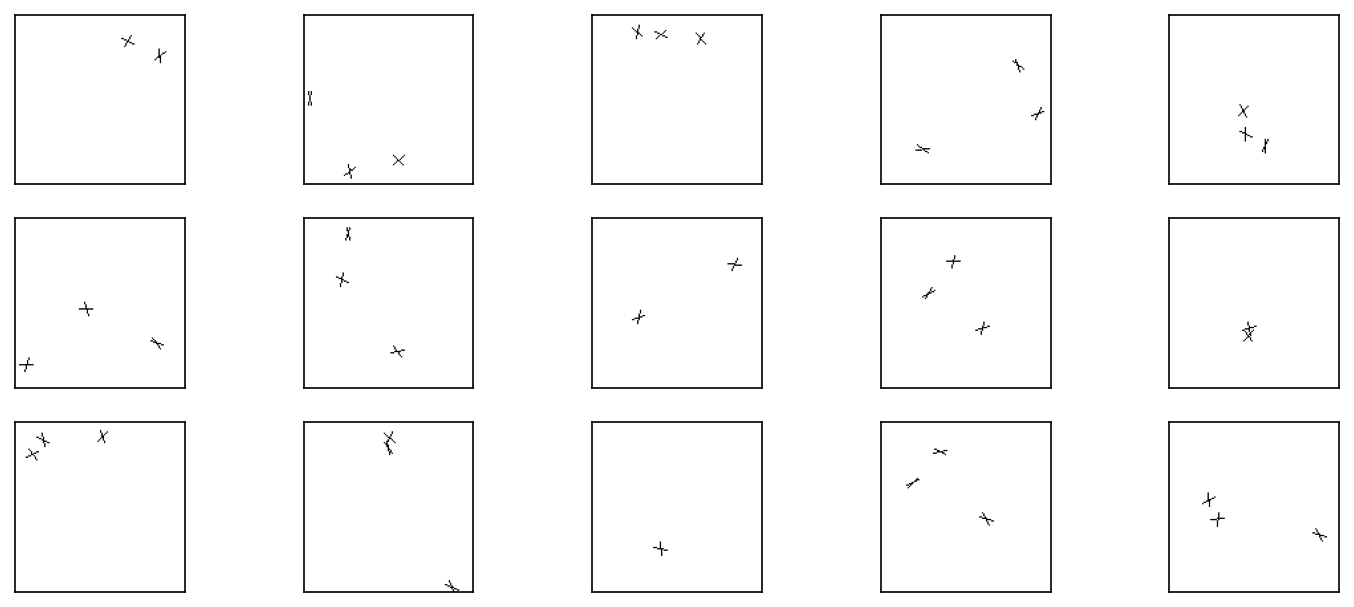

In [5]:
# Display examples of the dataset
eg_ds = crosses_train
# eg_ds = crosses_test
# eg_ds = Crosses_DS(500, line_len=(5,20), num_crosses=[2, 4, 6, 8], angular_sep=(90,90))

plt.rcParams['figure.dpi'] = 150
fig = plt.figure(figsize=(12, 5))
rows = 3
cols = 5

for i in range(rows * cols):
    fig.add_subplot(rows, cols, i + 1)
    plt.xticks([])
    plt.yticks([])
    img, cmap = eg_ds.visualise(eg_ds[random.randint(0, eg_ds.ds_size - 1)])
    plt.imshow(img, cmap=cmap)

### &emsp; &emsp; Training

In [6]:
# Train the HTM model (to root)
# model = HTM(
#     inp_dim=4,
#     emb_dim=18,     
#     device=device,
# )                                                                        


# model.train(
#     crosses_train,        # Crosses_DS(train_size, num_crss_dist=[4, 3, 2])   For P and B relationship demonstration
#     batch_macro,
    
#     # Curriculum Setup
#     merges = [0, 1, 2, 3, 4, -1],             
#     epochs = [10, 10, 10, 40, 20, 120],           

#     # LRs
#     lr_lu = [0.1, 0.001, 0.001, 0.0005, 0.0005, 0.0003],   
#     lr_mu = [None, 0.001, 0.001, 0.0005, 0.0005, 0.0003],
#     lr_clf = [None, 0.001, 0.001, 0.001, 0.001, 0.0005],
#     lr_pol = [None, 0.001, 0.001, 0.001, 0.001, 0.0005],

#     # LR Decays
#     lr_lu_decay = [5, None, 7, 30, 15, 95],                                  
#     lr_mu_decay = [None, None, 7, 30, 15, 95],                                                    
#     lr_clf_decay = [None]*5 + [95],
#     lr_pol_decay = [None]*5 + [95],

#     # Lambdas
#     lmbda_lif = [1e-2]*6,
#     lmbda_enc = [1e-3]*6,
#     lmbda_sl = [0.2]*6,
#     lmbda_trns = [0.2]*6,

#     lmbda_entrp=3,         # 1 & 10 for demonstration of entropy in learned environment  

#     # Extra
#     gen = True,
#     policy_v = "learned",
#     print_policy=True,
#     plt_ivl = 50,
#     save = True,
# )

In [7]:
# Load trained model
crosses_model = HTM(4, 18)
# crosses_model.load_model("crosses_hrst", "./trained_models")
crosses_model.load_model("crosses_lrnd", "./trained_models")
# crosses_model.load_model("crosses_nonUniform", "./trained_models")
# crosses_model.load_model("crosses_lmbdaEntrp_1", "./trained_models")
# crosses_model.load_model("crosses_lmbdaEntrp_10", "./trained_models")

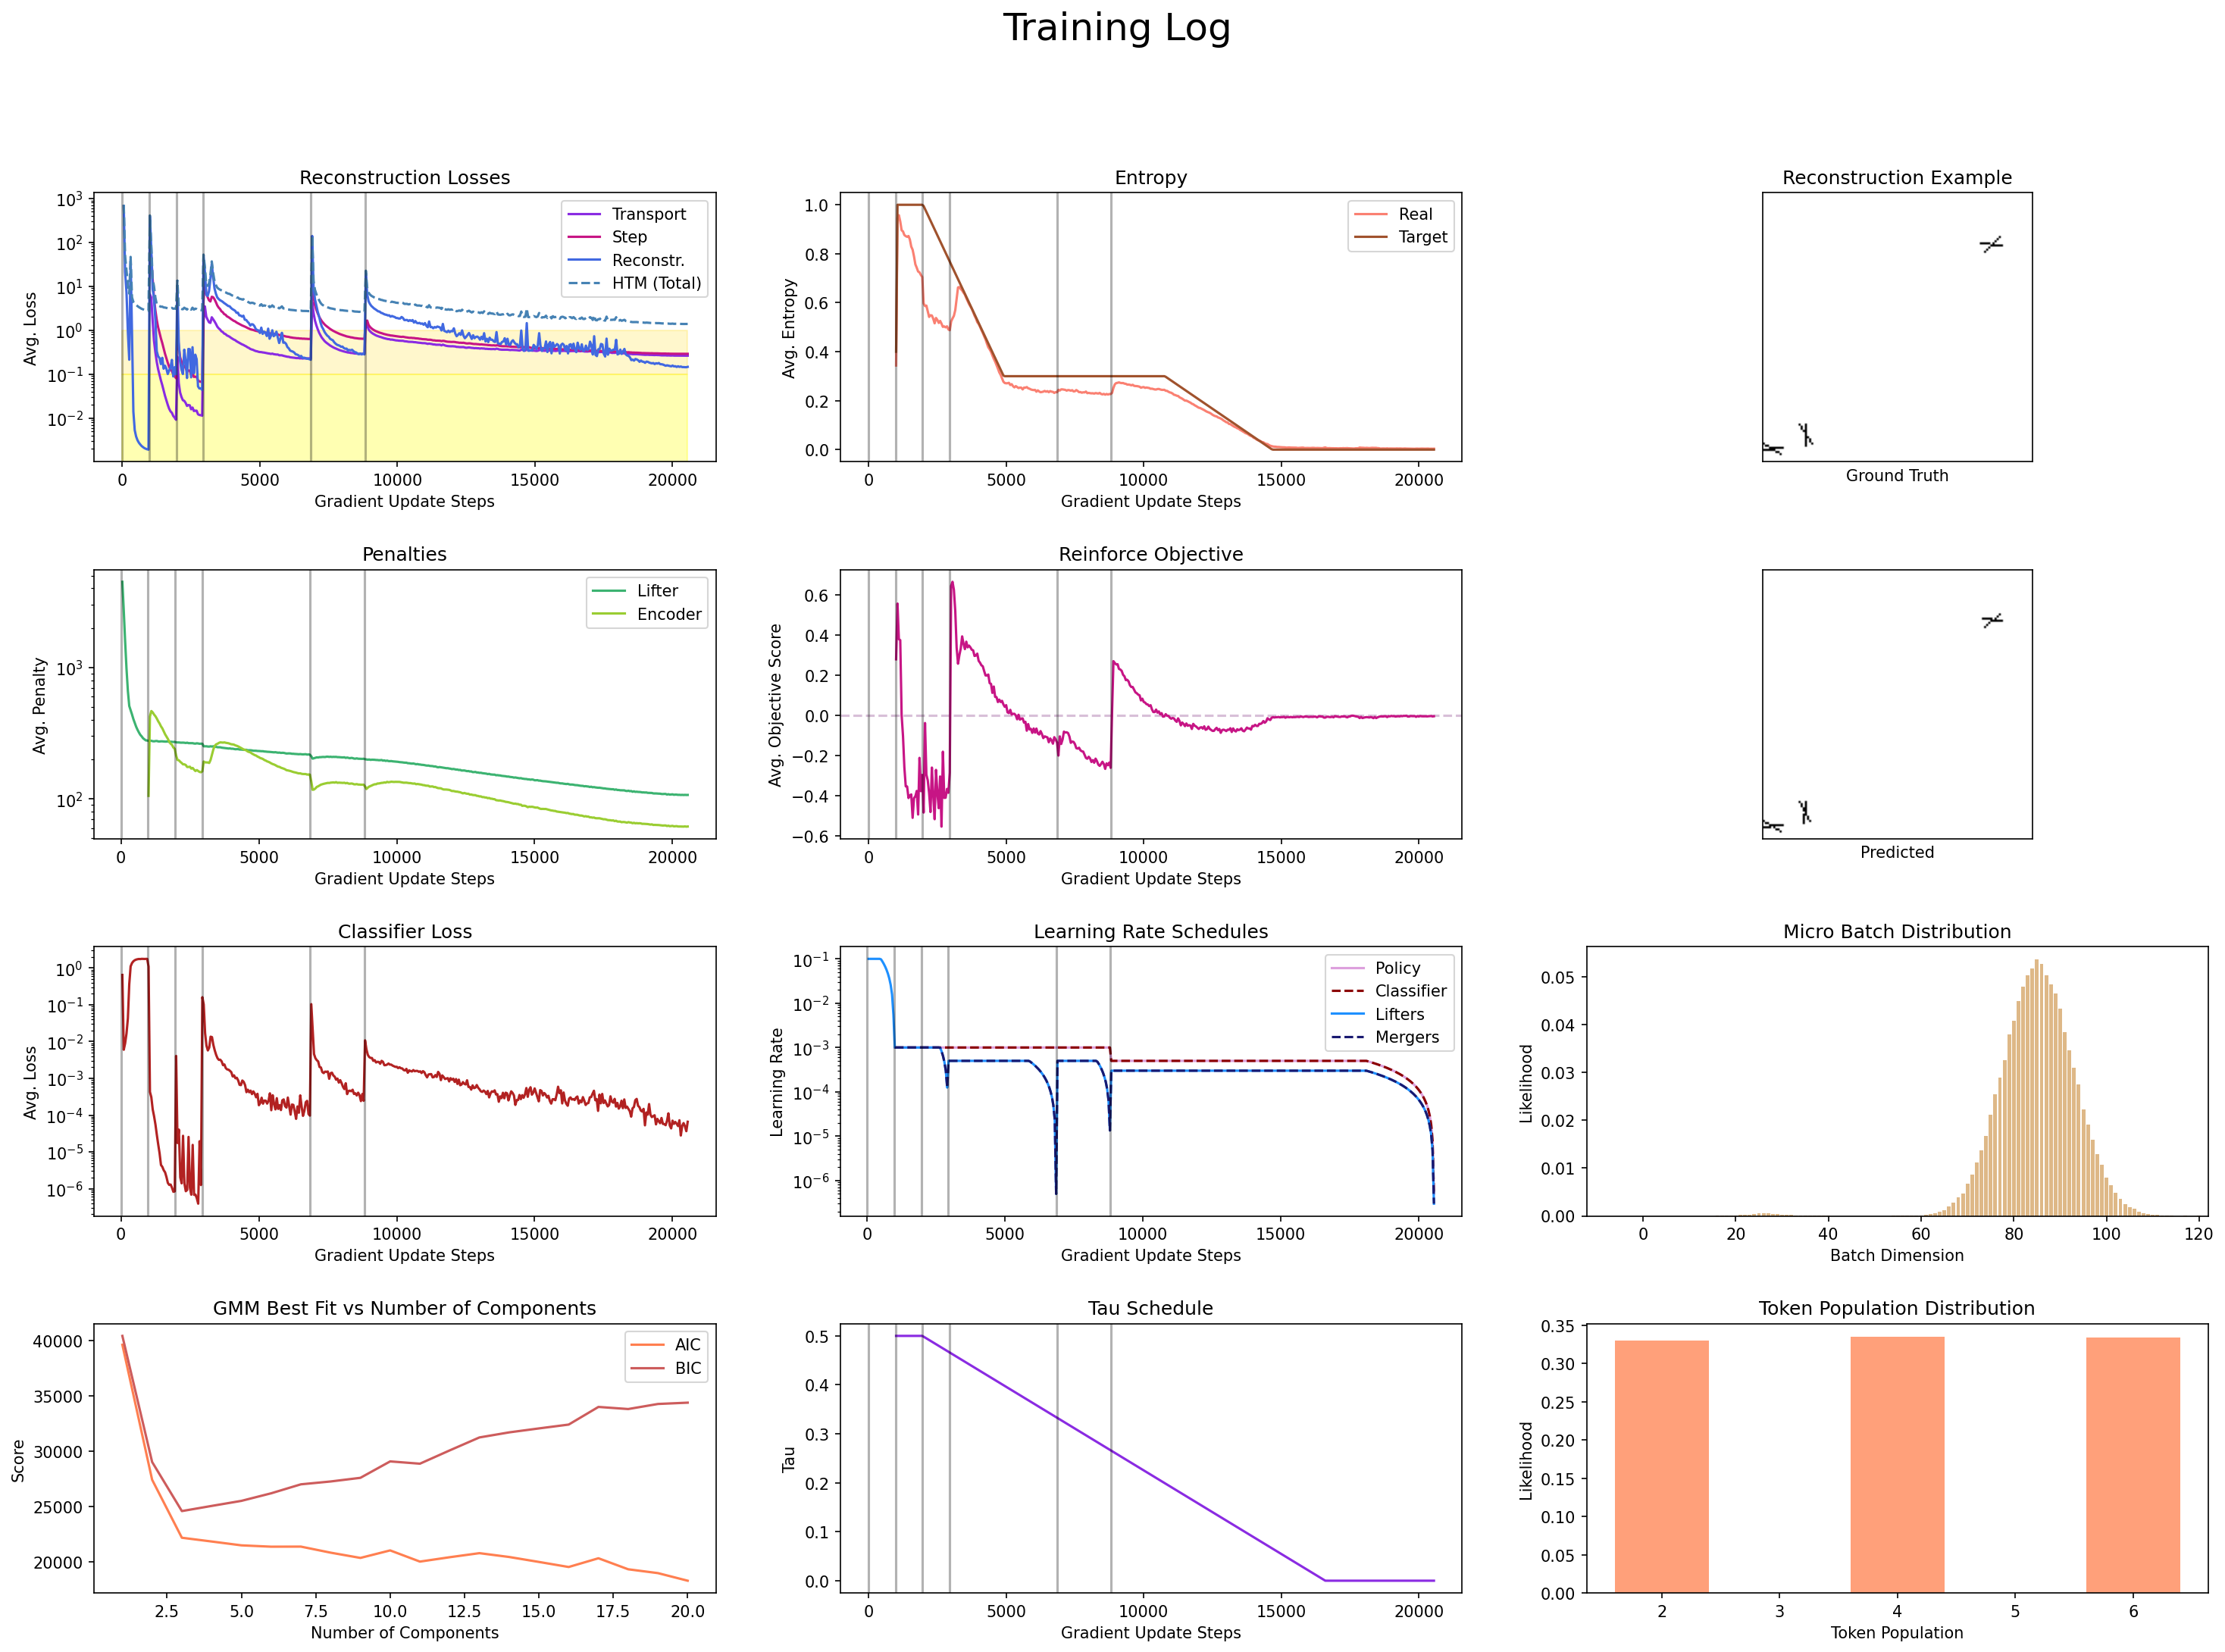



		Hyperparameters

inp_dim: 4
emb_dim: 18
mu_hidn: 256
clf_hidn: 256
plcy_hidn: 256
policy_v: learned
noise_std: 0.01
sftmx_eps: 1e-20
mask_val: -9e+20
std_eps: 1e-20
mvg_adv_sz: 10000
gen_step_limit: 100
decision_threshold: 0.5
device: cuda
batch_macro: 256
merges: [0, 1, 2, 3, 4, -1]
epochs: [10, 10, 10, 40, 20, 120]
lr_lu: [0.1, 0.001, 0.001, 0.0005, 0.0005, 0.0003]
lr_mu: [None, 0.001, 0.001, 0.0005, 0.0005, 0.0003]
lr_clf: [None, 0.001, 0.001, 0.001, 0.001, 0.0005]
lr_pol: [None, 0.001, 0.001, 0.001, 0.001, 0.0005]
lr_lu_decay: [5, None, 7, 30, 15, 95]
lr_mu_decay: [None, None, 7, 30, 15, 95]
lr_clf_decay: [None, None, None, None, None, 95]
lr_pol_decay: [None, None, None, None, None, 95]
lmbda_lif: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
lmbda_enc: [0.001, 0.001, 0.001, 0.001, 0.001, 0.001]
lmbda_sl: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
lmbda_trns: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
gen: True
wrk_entrp: 0.3
entrp_L: [0.05, 0.15, 0.2, 0.3]
lmbda_entrp: 3
tau_init: 0.5
tau_L: [0.05, 0.2]
lp: 

In [8]:
# Visualise the training results
# plt.rcParams.update({'font.size': 48})      # (for report) (24 or 48)
plt.rcParams.update({'font.size': 10})      # (default)
crosses_model.vis_log(show_hyper=True, specific=None)

### &emsp; &emsp; Policy Analysis

In [9]:
# Build the testing dataloader
crosses_test_dl = DataLoader(crosses_test, batch_macro, shuffle=True, collate_fn=crosses_test.collate_fn)

Test Input: 

 tensor([[[ 43.9828,  12.5435,  52.2732,   6.9516],
         [ 50.3979,   5.2925,  45.8580,  14.2026],
         [ 30.6547,  31.6198,  23.8347,  24.3063],
         [ 22.4384,  29.3413,  32.0510,  26.5849],
         [ 24.2062, 104.5360,  22.9875, 114.4614],
         [ 28.5353, 108.7165,  18.6584, 110.2809]]], device='cuda:0') torch.Size([1, 6, 4])


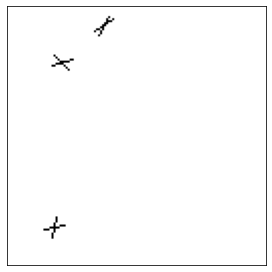

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

Test Ouput (-1 merges): 

 tensor([[[ 44.1519,  11.3704,  52.2545,   7.7252],
         [ 50.7362,   5.7332,  46.1087,  13.0465],
         [ 31.1940,  31.6162,  24.4686,  23.6919],
         [ 22.6464,  29.3734,  33.0020,  26.2705],
         [ 24.3119, 104.6041,  23.2754, 114.3657],
         [ 28.5432, 108.5929,  19.0321, 110.5098]]], device='cuda:0') torch.Size([1, 6, 4])


Actions: 
 tensor([[[3, 2],
         [1, 0],
         [6, 7],
         [4, 5],
         [8, 9]]], device='cuda:0') torch.Size([1, 5, 2])


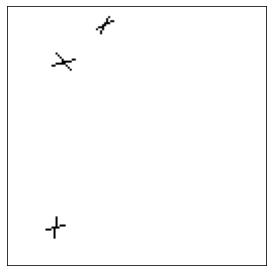

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



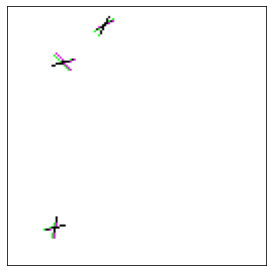

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



In [18]:
# Policy Examples
P_inst = 6            # The token population size, P, of the test instance to analyse
num_merges = -1       # Number of merges (actions) to perform


policy_eval(crosses_model, crosses_test_dl, P=P_inst, mrgs=num_merges)

In [53]:
#crosses_model.logits_mtx[crosses_model.logits_mtx == crosses_model.mask_val] = -torch.inf
crosses_model.logits_mtx

tensor([[[-9.0000e+20, -3.3936e+02, -3.3637e+02, -3.9211e+02, -9.0000e+20,
          -9.0000e+20],
         [-2.5215e+02, -9.0000e+20, -3.1175e+02, -3.5433e+02, -9.0000e+20,
          -9.0000e+20],
         [-4.2227e+02, -4.1314e+02, -9.0000e+20, -4.0989e+02, -9.0000e+20,
          -9.0000e+20],
         [-3.3260e+02, -3.1504e+02, -2.9303e+02, -9.0000e+20, -9.0000e+20,
          -9.0000e+20],
         [-9.0000e+20, -9.0000e+20, -9.0000e+20, -9.0000e+20, -9.0000e+20,
          -9.0000e+20],
         [-9.0000e+20, -9.0000e+20, -9.0000e+20, -9.0000e+20, -9.0000e+20,
          -9.0000e+20]]], device='cuda:0')

In [50]:
crosses_model.num_params()

	> Lifter: 90
	> Encoder: 79890
	> Decoder: 79908
	> Unlifter: 76

	> Classifier: 71170
	> Policy: 75521
	> Temperature: 1


### &emsp; &emsp; GMM Tuning

In [ ]:
# Tune the GMM
num_rt_samples = 500                       # Number of root samples to train the GMMs on
num_comp_range = list(range(1, 16, 1))     # Range of components to fit

# crosses_model.tune_gmm(crosses_train, batch_macro, num_rtx=num_rt_samples, ncomp_rnge=num_comp_range, live_plt=False)

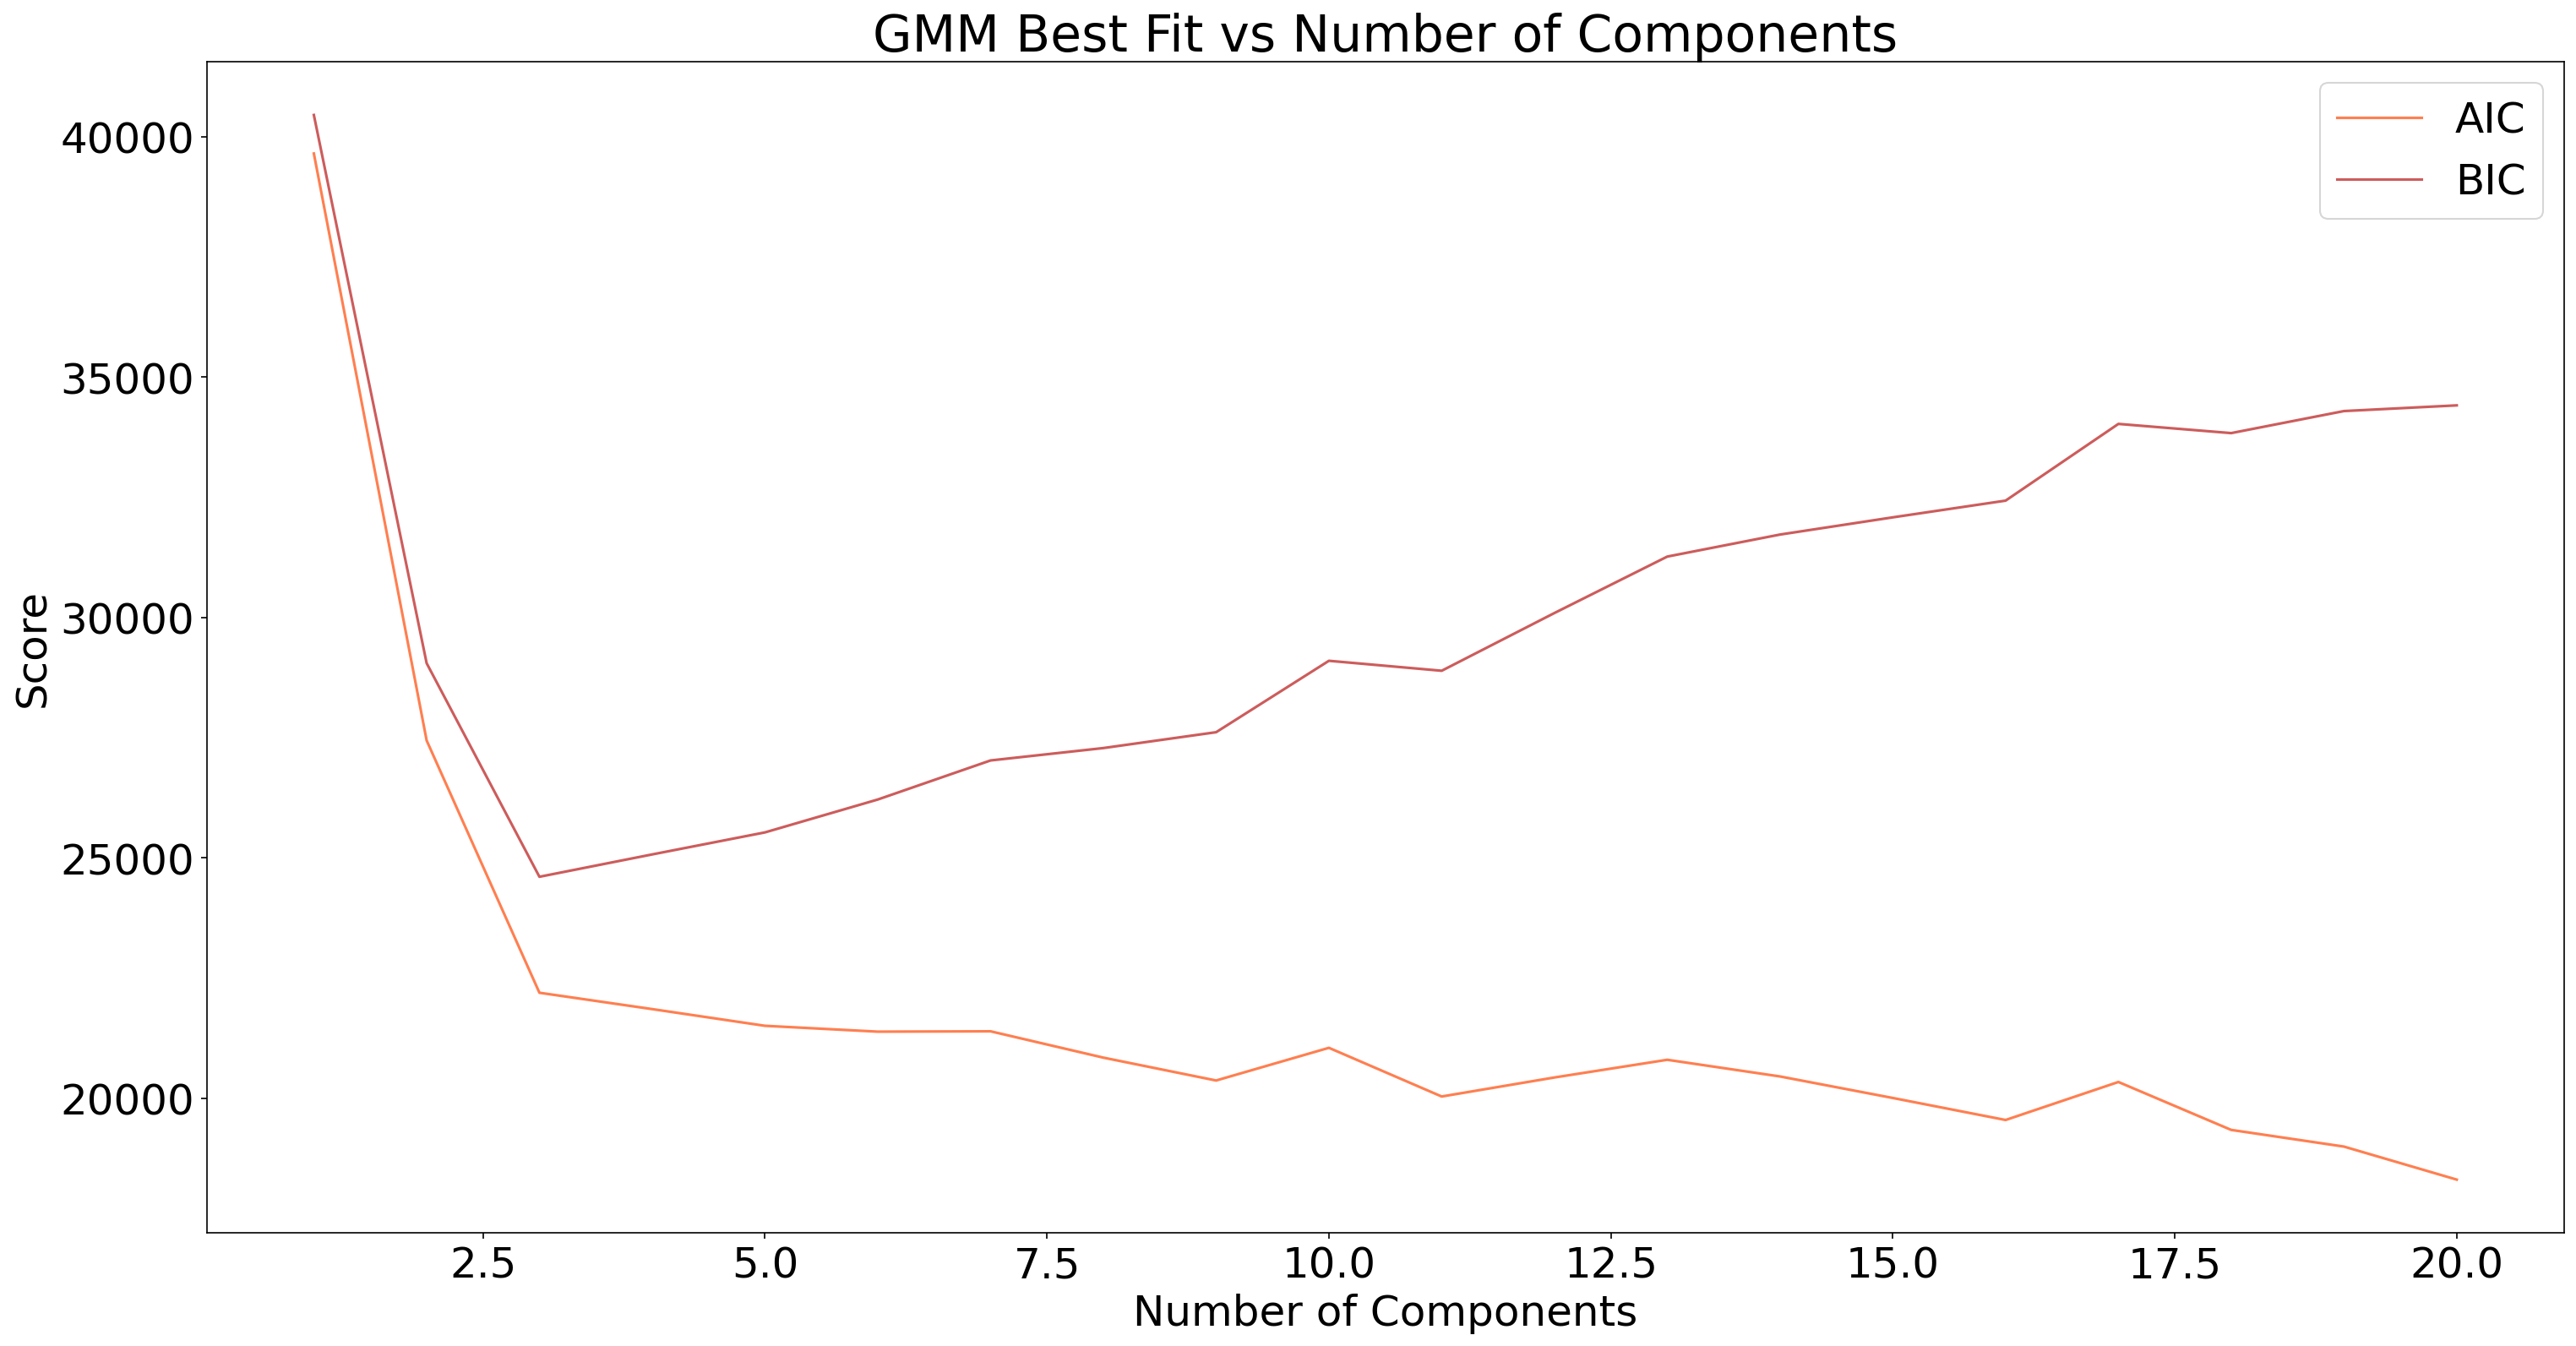

In [13]:
# See the result
plt.rcParams.update({'font.size': 24})      # (for report)
# plt.rcParams.update({'font.size': 10})      # (default)
crosses_model.vis_log(specific=10)

### &emsp; &emsp; Generation

In [9]:
# First fit a GMM
num_rt_samples = 500      # Number of root samples to fit the GMM to
num_comp = 3              # Number of components in the GMM

# rtx contains the root input data to fit the GMM to
#   as such, we first sample root tokens via the sample_rts() method

# crosses_model.fit_gmm(rtx=crosses_model.sample_rts(crosses_train, batch_macro, num_rtx=num_rt_samples), ncomp=num_comp)

In [10]:
# Resave model with the fitted GMM?

# crosses_model.save()

Sample Data: 

 tensor([[ 79.4589, 127.5861,  84.3244, 119.0924],
        [ 87.4099, 122.4998,  76.6928, 124.2463],
        [ 78.4739,  28.1358,  79.6213,  21.5662],
        [ 83.0599,  21.1194,  75.1229,  28.3399],
        [ 48.4133,  60.6292,  44.7766,  53.4587],
        [ 46.2865,  54.0808,  47.1558,  59.7521]], device='cuda:0') torch.Size([6, 4])


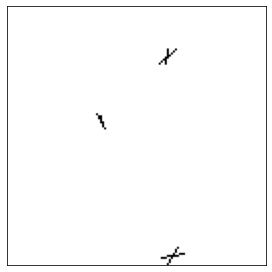

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



In [27]:
# Sample a new image
samp = crosses_model.sample()
print("Sample Data: \n\n", samp, samp.shape)

# Visualise the sample
plt.rcParams["figure.dpi"] = 70

out_vis = crosses_test.visualise(samp)
plt.imshow(out_vis[0], cmap=out_vis[1], vmin=0, vmax=255)
plt.xticks([])
plt.yticks([])
plt.show()
print("~"*100, "\n")



## Trees DS - 1 Merge, 2 Emb.

### &emsp; &emsp; The Dataset

In [3]:
# Make and save the training and testing sets

# trees_train = Trees_DS(train_size, heights=[3], dev_angle=-12.5, sep_angle=25, dist_factor=0.15, init_dist=90)
# trees_test = Trees_DS(test_size, heights=[3], dev_angle=-12.5, sep_angle=25, dist_factor=0.15, init_dist=90)
# save_pkl(trees_train, "trees_training_50000_narrow", save_dir="./datasets")
# save_pkl(trees_test, "trees_testing_20000_narrow", save_dir="./datasets")

# trees_train = Trees_DS(train_size, heights=[3])
# trees_test = Trees_DS(train_size, heights=[3])
# save_pkl(trees_train, "trees_training_50000_wide", save_dir="./datasets")
# save_pkl(trees_test, "trees_testing_20000_wide", save_dir="./datasets")

In [15]:
# Load the training and testing sets
# trees_train = load_pkl("./datasets/trees_training_50000_narrow.pkl")
# trees_test = load_pkl("./datasets/trees_testing_20000_narrow.pkl")

trees_train = load_pkl("./datasets/trees_training_50000_wide.pkl")
trees_test = load_pkl("./datasets/trees_testing_20000_wide.pkl")

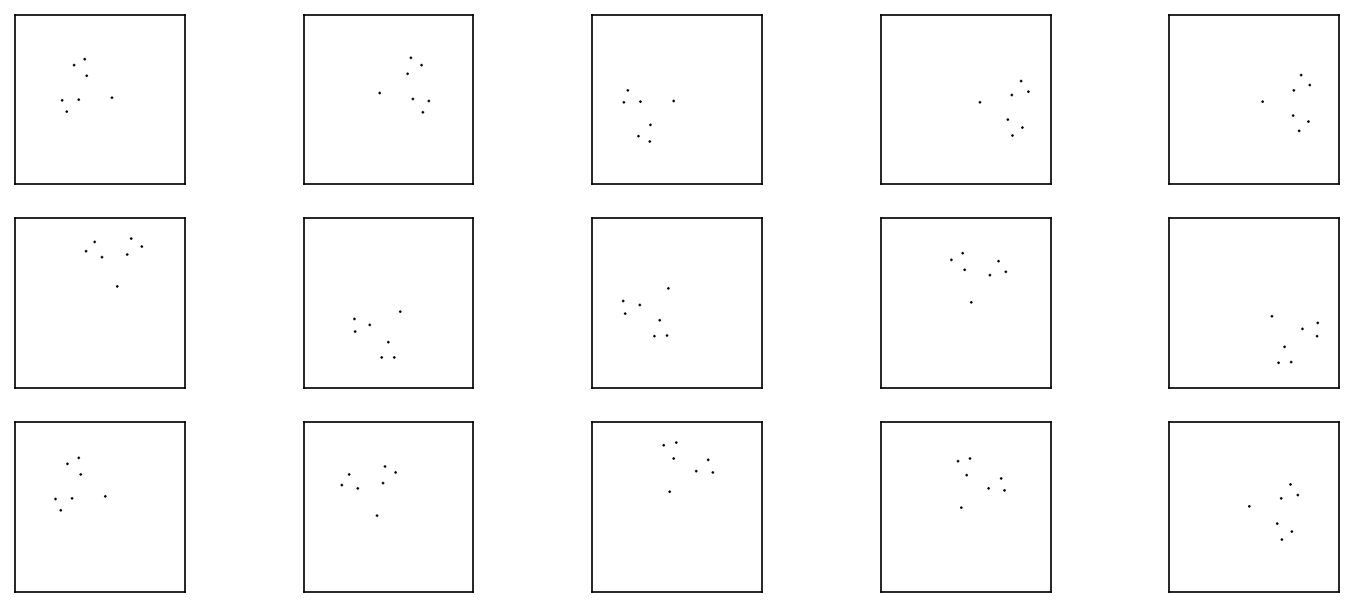

In [16]:
# Display examples of the dataset
eg_ds = trees_train
# eg_ds = trees_test
# eg_ds = Trees_DS(500, heights=[5], point_radius=0.5)

plt.rcParams['figure.dpi'] = 150
fig = plt.figure(figsize=(12, 5))
rows = 3
cols = 5

for i in range(rows * cols):
    fig.add_subplot(rows, cols, i + 1)
    plt.xticks([])
    plt.yticks([])
    img, cmap = eg_ds.visualise(eg_ds[random.randint(0, eg_ds.ds_size - 1)])
    plt.imshow(img, cmap=cmap)

### &emsp; &emsp; Training

In [17]:
# Train the HTM model (2 emb. dim, 1 merge only)
# model = HTM(
#     inp_dim=2,
#     emb_dim=2,      
#     device=device                                 
# )                                                                        
                                                                            
                                                                           
                                                                            
# model.train(
#     trees_train,
#     batch_macro,
    
#     # Curriculum Setup
#     merges = [0, 1],          
#     epochs = [5, 80],    

#     # LRs
#     lr_lu = [0.05, 0.0005],       
#     lr_mu = [None, 0.0005],
#     lr_clf = [None]*2,
#     lr_pol = [None, 0.0005],

#     # LR Decays
#     lr_lu_decay = [2, 60],        
#     lr_mu_decay = [None, 60],                                                   
#     lr_clf_decay = [None]*2,
#     lr_pol_decay = [None, 60],

#     # Lambdas
#     lmbda_lif = [None]*2,
#     lmbda_enc = [None]*2,
#     lmbda_sl = [0.2]*2,
#     lmbda_trns = [0.2]*2,

#     lmbda_entrp=5,
#     entrp_L=[0.05, 0.10, 0.45, 0.15],

#     # Extra
#     gen = False,
#     policy_v = "learned", 
#     print_policy=True,
#     plt_ivl = 50,
#     save = True
# )

In [18]:
# Load trained model
tree1m_model = HTM(2, 2)
# tree1m_model.load_model("trees_lrnd_2emb_1mrg_narrow", "./trained_models")
tree1m_model.load_model("trees_lrnd_2emb_1mrg_wide", "./trained_models")

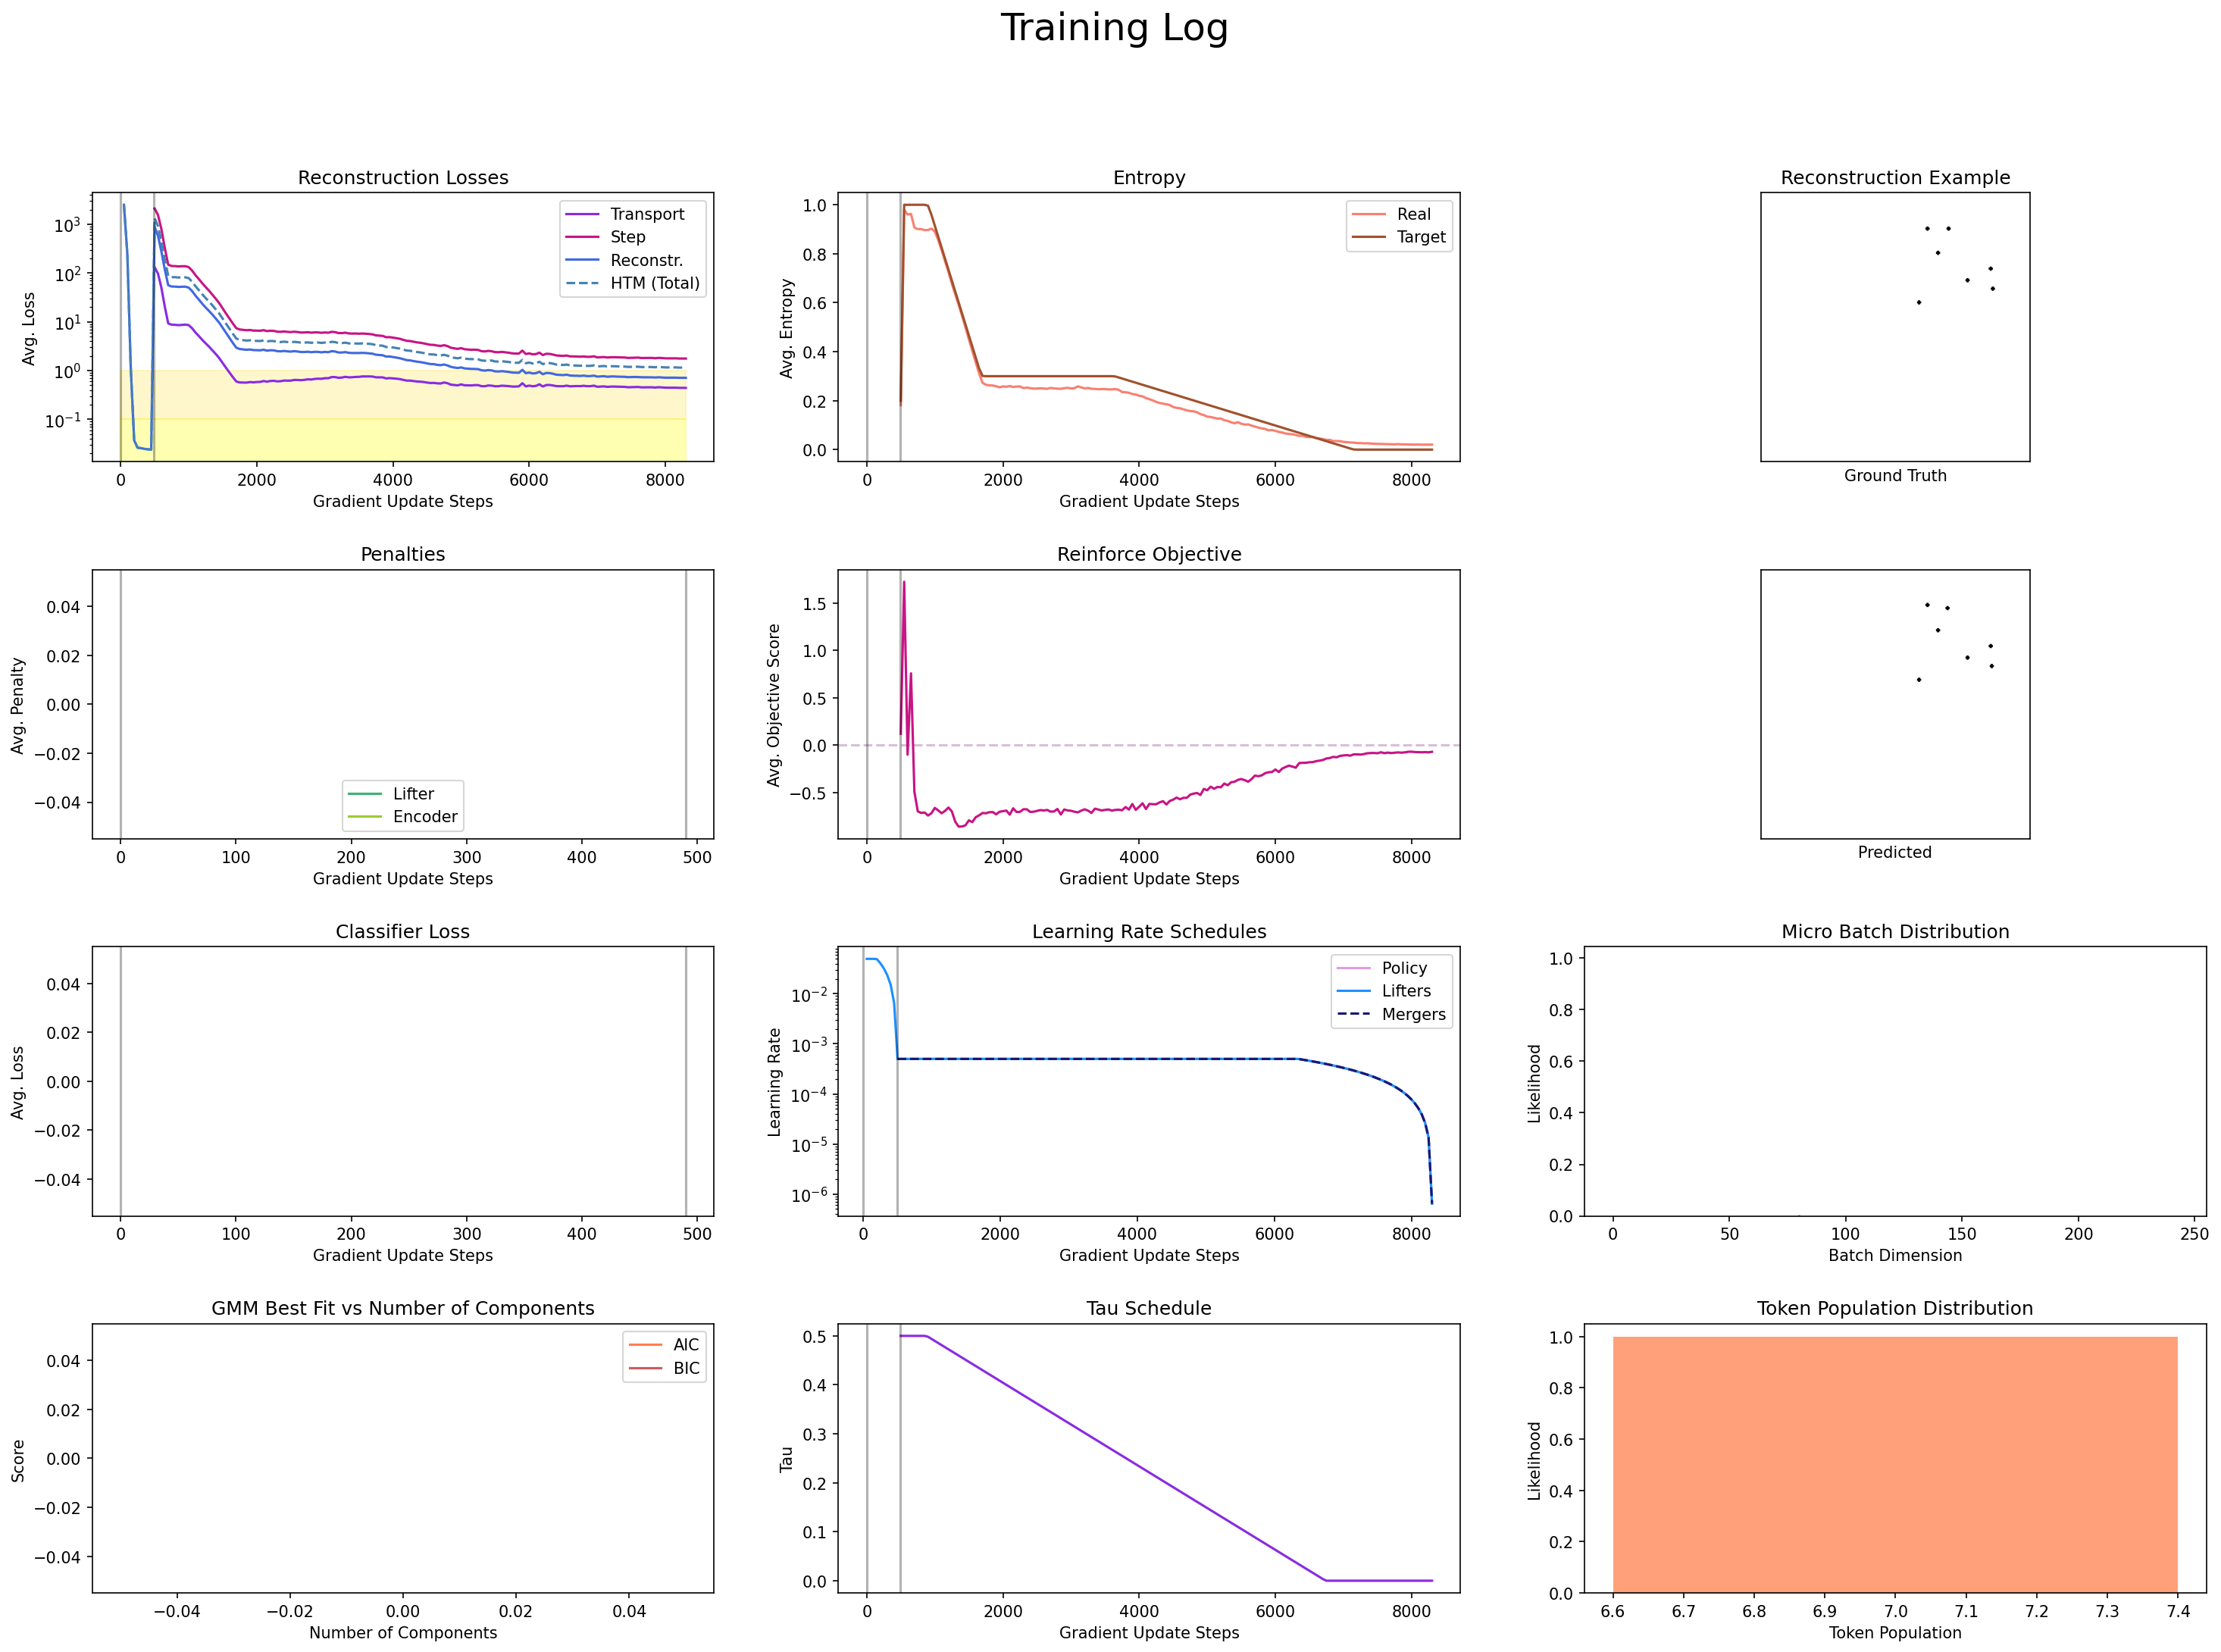



		Hyperparameters

inp_dim: 2
emb_dim: 2
mu_hidn: 256
clf_hidn: 256
plcy_hidn: 256
policy_v: learned
noise_std: 0.01
sftmx_eps: 1e-20
mask_val: -9e+20
std_eps: 1e-20
mvg_adv_sz: 10000
gen_step_limit: 100
decision_threshold: 0.5
device: cuda
batch_macro: 256
merges: [0, 1]
epochs: [5, 80]
lr_lu: [0.05, 0.0005]
lr_mu: [None, 0.0005]
lr_clf: [None, None]
lr_pol: [None, 0.0005]
lr_lu_decay: [2, 60]
lr_mu_decay: [None, 60]
lr_clf_decay: [None, None]
lr_pol_decay: [None, 60]
lmbda_lif: [None, None]
lmbda_enc: [None, None]
lmbda_sl: [0.2, 0.2]
lmbda_trns: [0.2, 0.2]
gen: False
wrk_entrp: 0.3
entrp_L: [0.05, 0.1, 0.45, 0.15]
lmbda_entrp: 5
tau_init: 0.5
tau_L: [0.05, 0.2]
lp: 0.01
plcy_l2: 1e-05
plt_ivl: 50
g_accum_f: 2
lr_t: 0.05
sched_bnd: 0.001
entrp_eps: 0.0005
tune_num_rtx: 500
tune_ncomp_rnge: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
tune_cov_type: full
tune_max_iter: 100
tune_tol: 0.001
print_policy: True
reg: False


In [19]:
# Visualise the training results
# plt.rcParams.update({'font.size': 24})      # (for report)
plt.rcParams.update({'font.size': 10})      # (default)
tree1m_model.vis_log(show_hyper=True, specific=None)

### &emsp; &emsp; Policy Analysis

In [20]:
# Build the testing dataloader
test_dl = DataLoader(trees_test, batch_macro, shuffle=True, collate_fn=trees_test.collate_fn)

Test Input: 

 tensor([[[159.3949, 156.2991],
         [124.9771, 192.5678],
         [100.0380, 194.3117],
         [108.5757, 211.4355],
         [160.7037, 206.2820],
         [160.2674, 231.2782],
         [178.0702, 224.2655]]], device='cuda:0') torch.Size([1, 7, 2])


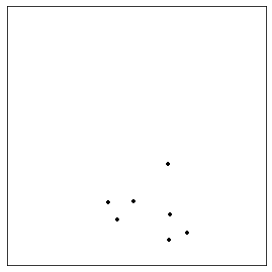

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

Test Ouput (1 merges): 

 tensor([[[159.3133, 156.2445],
         [123.3740, 191.3898],
         [ 99.9994, 194.2971],
         [110.0577, 212.6543],
         [160.5579, 206.1656],
         [160.0604, 231.1456],
         [177.8430, 224.1019]]], device='cuda:0') torch.Size([1, 7, 2])


Actions: 
 tensor([[[3, 1]]], device='cuda:0') torch.Size([1, 1, 2])


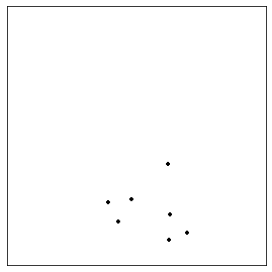

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



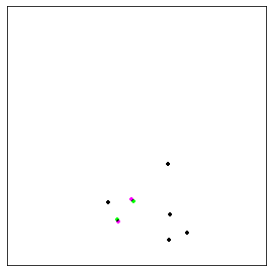

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



In [24]:
# Policy Examples
P_inst = 7            # The token population size, P, of the test instance to analyse (fixed as 7 in this case)
num_merges = 1        # Number of merges (actions) to perform


policy_eval(tree1m_model, test_dl, P=P_inst, mrgs=num_merges)

In [ ]:
#tree1m_model.logits_mtx[tree1m_model.logits_mtx == tree1m_model.mask_val] = -torch.inf
tree1m_model.logits_mtx

tensor([[[-9.0000e+20, -9.0000e+20, -9.0000e+20, -9.0000e+20, -9.0000e+20,
          -9.0000e+20, -9.0000e+20, -9.0000e+20, -9.0000e+20, -9.0000e+20,
          -9.0000e+20, -9.0000e+20],
         [-9.0000e+20, -9.0000e+20, -9.0000e+20, -9.0000e+20, -9.0000e+20,
          -9.0000e+20, -9.0000e+20, -9.0000e+20, -9.0000e+20, -9.0000e+20,
          -9.0000e+20, -9.0000e+20],
         [-9.0000e+20, -9.0000e+20, -9.0000e+20, -9.0000e+20, -9.0000e+20,
          -9.0000e+20, -9.0000e+20, -9.0000e+20, -9.0000e+20, -9.0000e+20,
          -9.0000e+20, -9.0000e+20],
         [-9.0000e+20, -9.0000e+20, -9.0000e+20, -9.0000e+20, -9.0000e+20,
          -9.0000e+20, -9.0000e+20, -9.0000e+20, -9.0000e+20, -9.0000e+20,
          -9.0000e+20, -9.0000e+20],
         [-9.0000e+20, -9.0000e+20, -9.0000e+20, -9.0000e+20, -9.0000e+20,
          -9.0000e+20, -9.0000e+20, -9.0000e+20, -9.0000e+20, -9.0000e+20,
          -9.0000e+20, -9.0000e+20],
         [-9.0000e+20, -9.0000e+20, -9.0000e+20, -9.0000e+20, -9.

In [12]:
tree1m_model.num_params()

	> Lifter: 6
	> Encoder: 67586
	> Decoder: 67588
	> Unlifter: 6

	> Classifier: 67074
	> Policy: 67329
	> Temperature: 1


## Trees DS - Merge to Root

### &emsp; &emsp; The Dataset

In [4]:
# Load the training and testing sets
trees_train = load_pkl("./datasets/trees_training_50000_narrow.pkl")
trees_test = load_pkl("./datasets/trees_testing_20000_narrow.pkl")

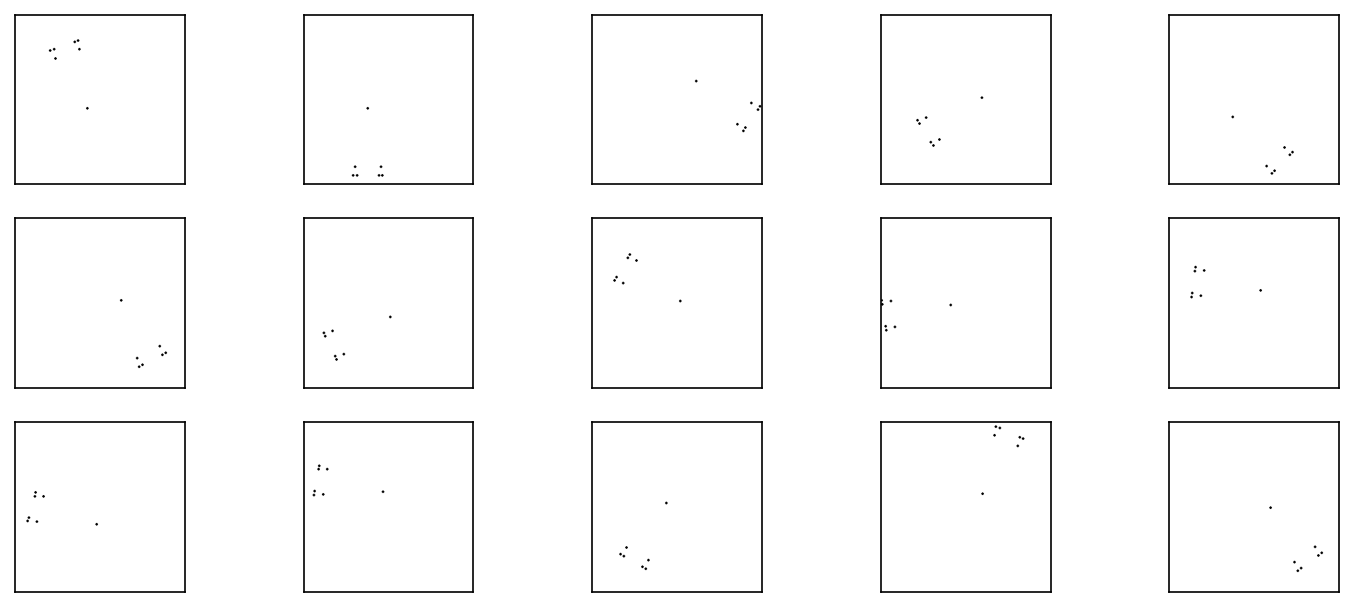

In [5]:
# Display examples of the dataset
eg_ds = trees_train
# eg_ds = trees_test
# eg_ds = Trees_DS(500, heights=[5], point_radius=0.5)

plt.rcParams['figure.dpi'] = 150
fig = plt.figure(figsize=(12, 5))
rows = 3
cols = 5

for i in range(rows * cols):
    fig.add_subplot(rows, cols, i + 1)
    plt.xticks([])
    plt.yticks([])
    img, cmap = eg_ds.visualise(eg_ds[random.randint(0, eg_ds.ds_size - 1)])
    plt.imshow(img, cmap=cmap)

### &emsp; &emsp; Training

In [6]:
# Train the HTM model (to root)
# model = HTM(
#     inp_dim=2,
#     emb_dim=7,     
#     device=device,
# )                                                                        


# model.train(
#     trees_train,
#     batch_macro,
    
#     # Curriculum Setup
#     merges = [0, 1, 2, 3, 4, 5, -1],             
#     epochs = [5, 8, 16, 16, 16, 100, 700],           

#     # LRs
#     lr_lu = [0.05, 0.001, 0.0002, 0.0002, 0.0002, 0.0002, 0.0001],       
#     lr_mu = [None, 0.001, 0.0002, 0.0002, 0.0002, 0.0002, 0.0001],
#     lr_clf = [None, 0.001, 0.0005, 0.0005, 0.0005, 0.0005, 0.0002],
#     lr_pol = [None, 0.001, 0.0005, 0.0005, 0.0005, 0.0005, 0.0002],

#     # LR Decays
#     lr_lu_decay =  [2, 4, 12, 12, 12, 85, 660],                                  
#     lr_mu_decay = [None, 4, 12, 12, 12, 85, 660],                                                    
#     lr_clf_decay = [None]*6 + [660],
#     lr_pol_decay = [None]*6 + [660],

#     # Lambdas
#     lmbda_lif = [2e-4]*7,
#     lmbda_enc = [2e-5]*7,   
#     lmbda_sl = [0.2]*7,
#     lmbda_trns = [0.2]*7,

#     # Extra
#     gen = True,
#     policy_v = "heuristic",   # learned
#     print_policy=True,
#     plt_ivl = 50,
#     save = True,
#     tune_ncomp_rnge = list(range(1, 101, 1)),


#     # Entropy Setup (not default)
#     entrp_L = [0.005, 0.015, 0.45, 0.15],

#     lmbda_entrp=3 
# )

In [7]:
# Load trained model
trees_model = HTM(2, 7)
trees_model.load_model("trees_lrnd", "./trained_models")
# trees_model.load_model("trees_hrst", "./trained_models")

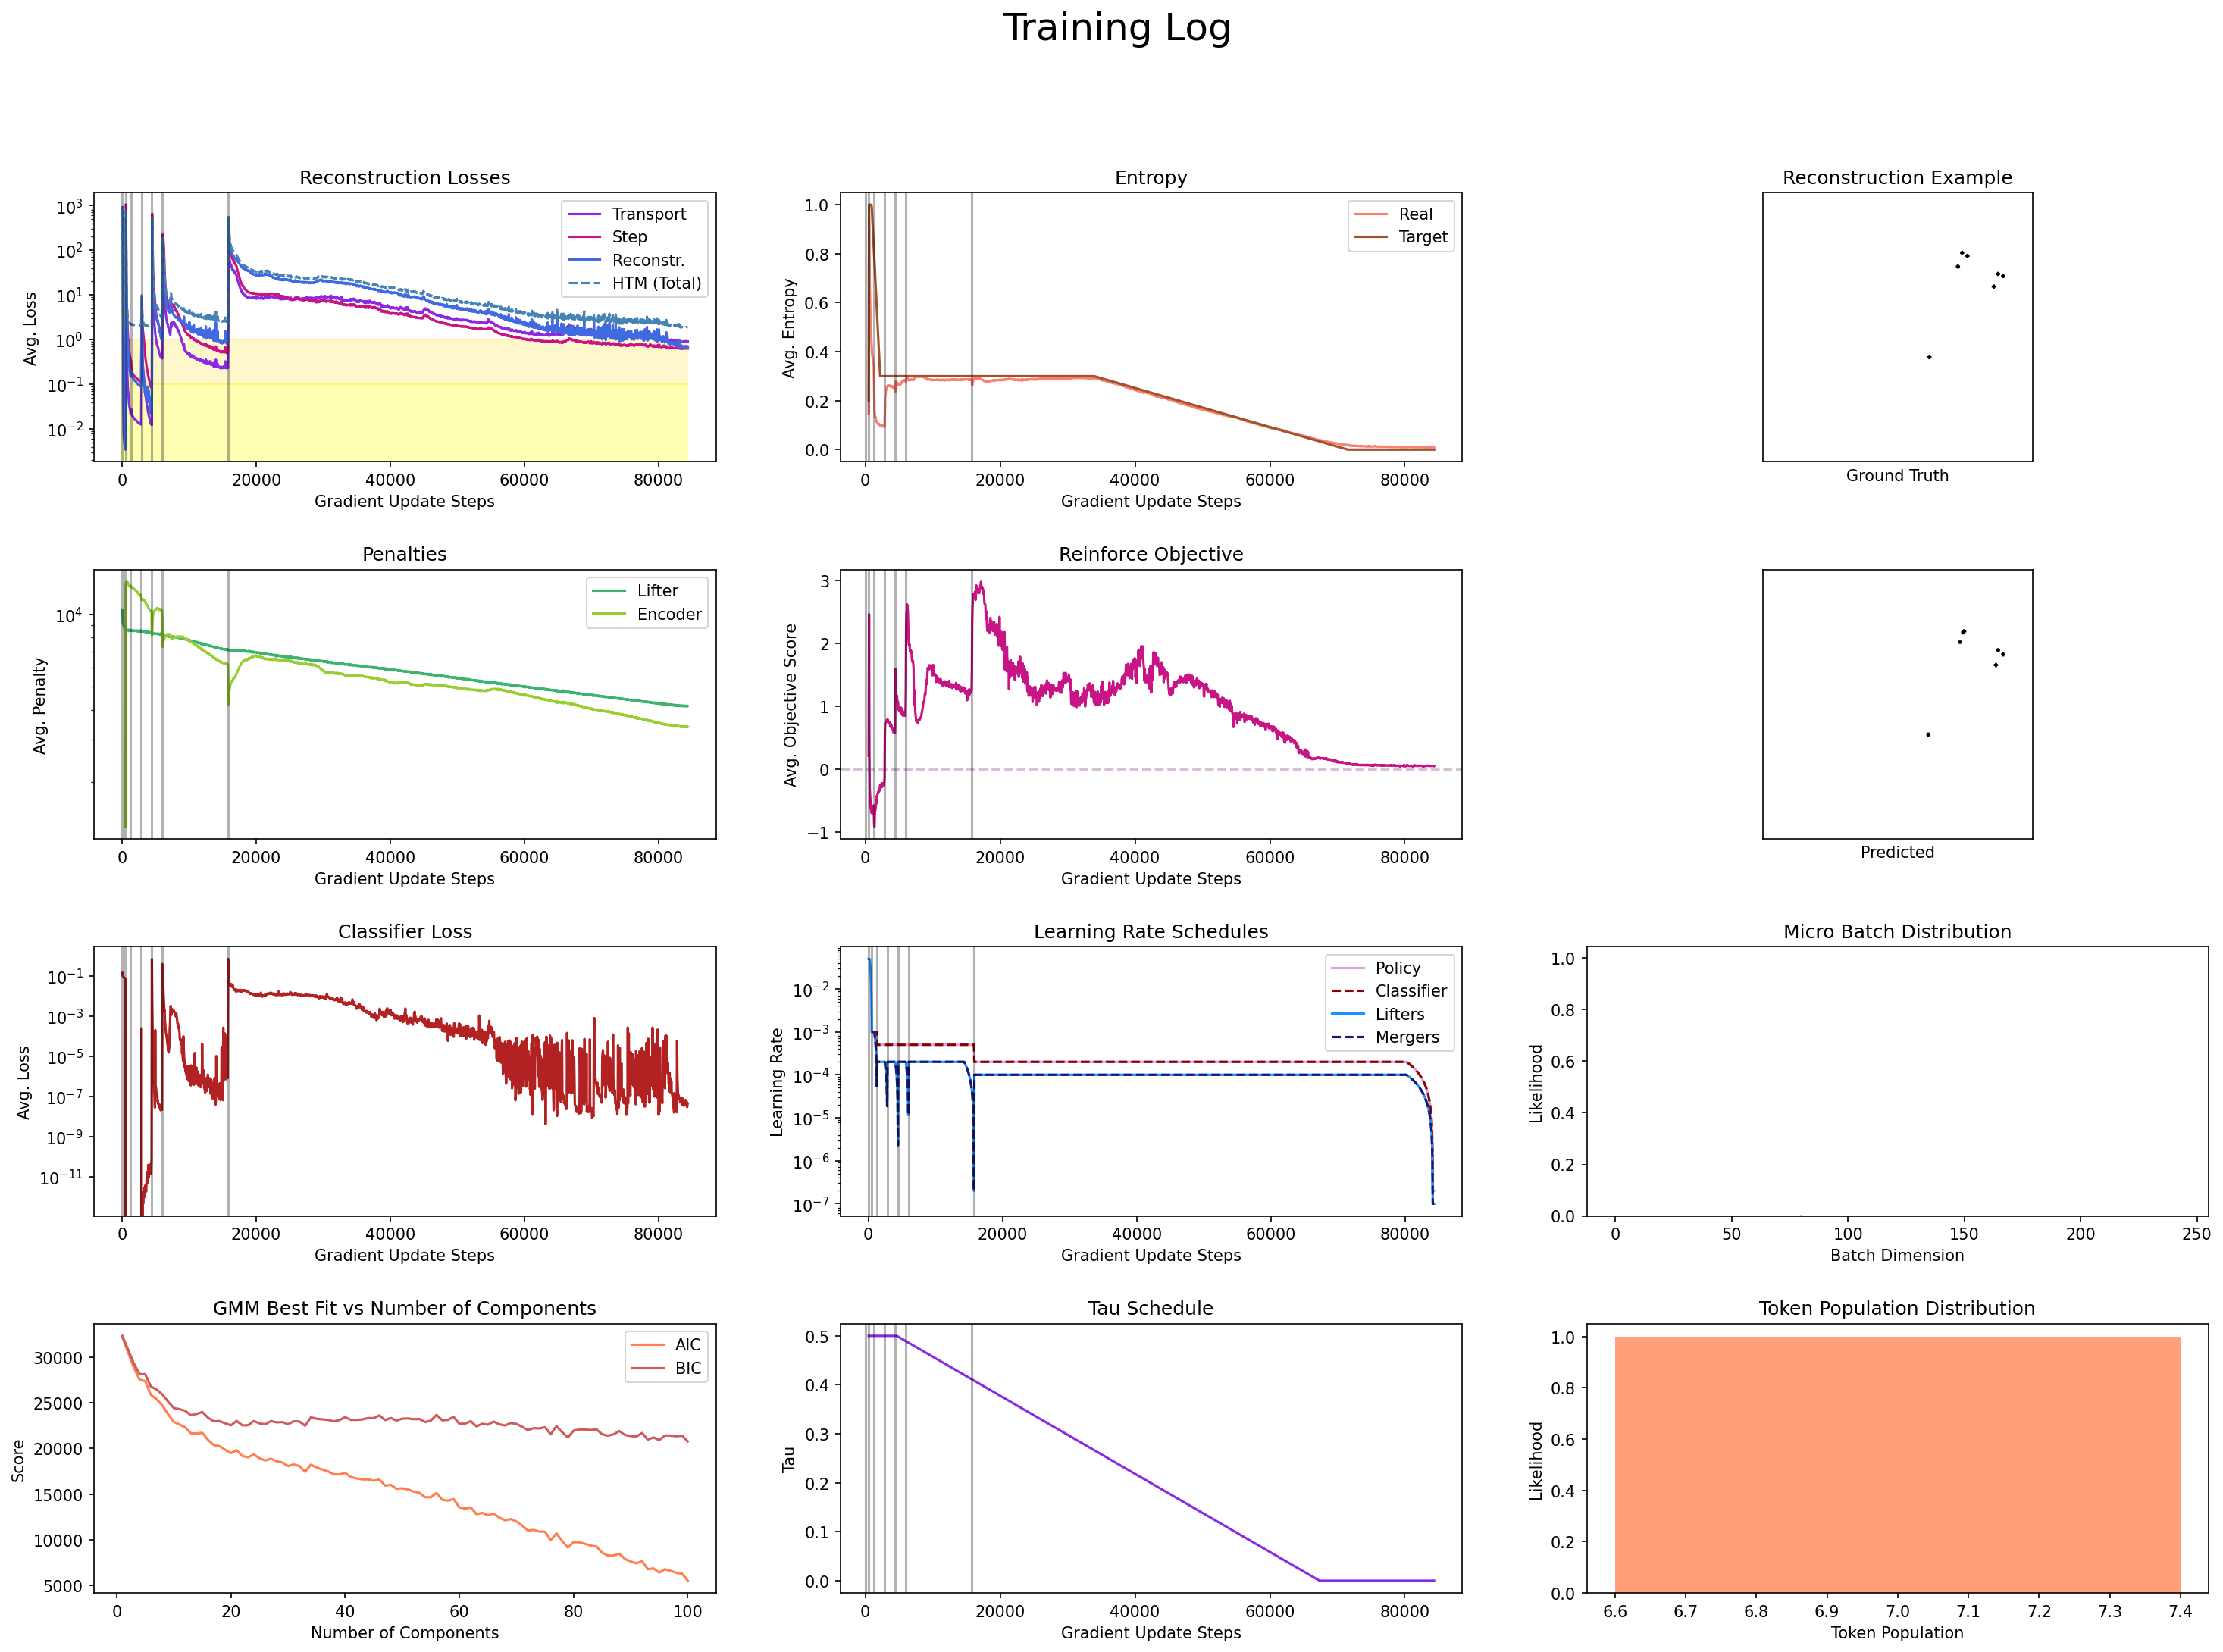



		Hyperparameters

inp_dim: 2
emb_dim: 7
mu_hidn: 256
clf_hidn: 256
plcy_hidn: 256
policy_v: learned
noise_std: 0.01
sftmx_eps: 1e-20
mask_val: -9e+20
std_eps: 1e-20
mvg_adv_sz: 10000
gen_step_limit: 100
decision_threshold: 0.5
device: cuda
batch_macro: 256
merges: [0, 1, 2, 3, 4, 5, -1]
epochs: [5, 8, 16, 16, 16, 100, 700]
lr_lu: [0.05, 0.001, 0.0002, 0.0002, 0.0002, 0.0002, 0.0001]
lr_mu: [None, 0.001, 0.0002, 0.0002, 0.0002, 0.0002, 0.0001]
lr_clf: [None, 0.001, 0.0005, 0.0005, 0.0005, 0.0005, 0.0002]
lr_pol: [None, 0.001, 0.0005, 0.0005, 0.0005, 0.0005, 0.0002]
lr_lu_decay: [2, 4, 12, 12, 12, 85, 660]
lr_mu_decay: [None, 4, 12, 12, 12, 85, 660]
lr_clf_decay: [None, None, None, None, None, None, 660]
lr_pol_decay: [None, None, None, None, None, None, 660]
lmbda_lif: [0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002]
lmbda_enc: [2e-05, 2e-05, 2e-05, 2e-05, 2e-05, 2e-05, 2e-05]
lmbda_sl: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
lmbda_trns: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
gen: T

In [8]:
# Visualise the training results
# plt.rcParams.update({'font.size': 24})      # (for report)
plt.rcParams.update({'font.size': 10})      # (default)
trees_model.vis_log(show_hyper=True, specific=None)

### &emsp; &emsp; Policy Analysis

In [9]:
# Build the testing dataloader
trees_test_dl = DataLoader(trees_test, batch_macro, shuffle=True, collate_fn=trees_test.collate_fn)

Test Input: 

 tensor([[[124.0574, 134.0553],
         [101.5232, 221.1886],
         [ 98.1431, 234.2586],
         [103.9834, 234.4625],
         [140.4586, 222.5482],
         [137.0785, 235.6182],
         [142.9188, 235.8222]]], device='cuda:0') torch.Size([1, 7, 2])


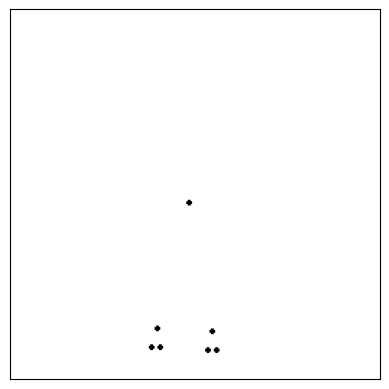

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

Test Ouput (-1 merges): 

 tensor([[[123.5753, 134.1348],
         [101.8489, 221.5265],
         [ 98.3900, 233.7747],
         [103.9741, 233.9227],
         [140.6451, 222.7030],
         [138.6566, 235.5475],
         [141.1552, 235.7137]]], device='cuda:0') torch.Size([1, 7, 2])


Actions: 
 tensor([[[ 1,  2],
         [ 4,  5],
         [ 6,  8],
         [ 3,  7],
         [ 0,  9],
         [10, 11]]], device='cuda:0') torch.Size([1, 6, 2])


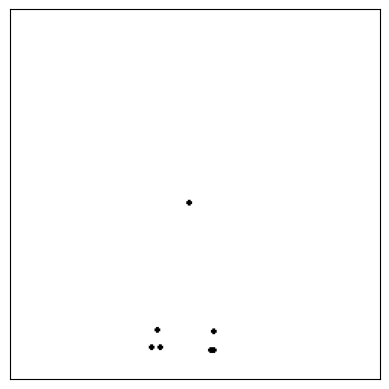

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



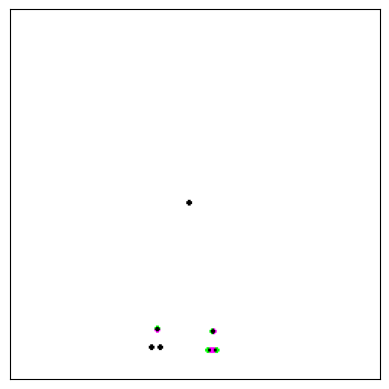

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



In [16]:
# Policy Examples
P_inst = 7            # The token population size, P, of the test instance to analyse (fixed as 7 in this case)
num_merges = -1       # Number of merges (actions) to perform


policy_eval(trees_model, trees_test_dl, P=P_inst, mrgs=num_merges, fig_dpi=100)

In [ ]:
# trees_model.logits_mtx[trees_model.logits_mtx == trees_model.mask_val] = -torch.inf
trees_model.logits_mtx

tensor([[[     -inf, -210.1906, -264.0364, -257.0938,      -inf,      -inf,
          -255.6967],
         [-319.7172,      -inf,  110.1359,   79.7949,      -inf,      -inf,
          -117.5165],
         [-362.5858,  -38.5119,      -inf,   15.9721,      -inf,      -inf,
          -153.4055],
         [-354.1305,  -25.5440,   49.2303,      -inf,      -inf,      -inf,
          -125.9657],
         [     -inf,      -inf,      -inf,      -inf,      -inf,      -inf,
               -inf],
         [     -inf,      -inf,      -inf,      -inf,      -inf,      -inf,
               -inf],
         [-314.2806,  -76.5555,  -43.8661,  -30.6422,      -inf,      -inf,
               -inf]]], device='cuda:0')

In [22]:
trees_model.num_params()

	> Lifter: 21
	> Encoder: 71431
	> Decoder: 71438
	> Unlifter: 16

	> Classifier: 68354
	> Policy: 69889
	> Temperature: 1


### &emsp; &emsp; GMM Tuning

In [29]:
# Tune the GMM
num_rt_samples = 500                       # Number of root samples to train the GMMs on
num_comp_range = list(range(1, 51, 1))     # Range of components to fit

trees_model.tune_gmm(trees_train, batch_macro, num_rtx=num_rt_samples, ncomp_rnge=num_comp_range, live_plt=False)

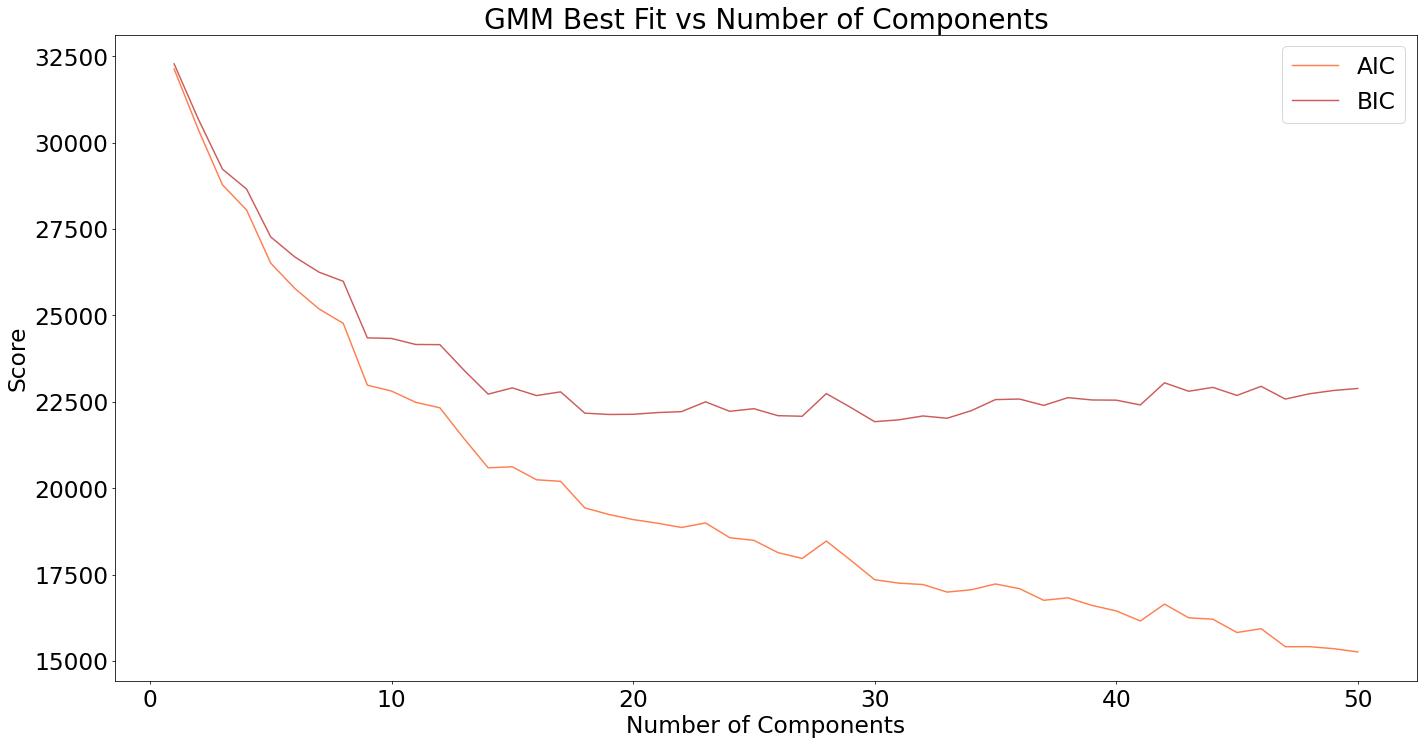

In [30]:
# See the result
plt.rcParams.update({'font.size': 24})      # (for report)
# plt.rcParams.update({'font.size': 10})      # (default)
trees_model.vis_log(specific=10)

### &emsp; &emsp; Generation

In [8]:
# First fit a GMM
num_rt_samples = 500      # Number of root samples to fit the GMM to
num_comp = 18              # Number of components in the GMM

# rtx contains the root input data to fit the GMM to
#   as such, we first sample root tokens via the sample_rts() method

# trees_model.fit_gmm(rtx=trees_model.sample_rts(trees_train, batch_macro, num_rtx=num_rt_samples), ncomp=num_comp)

In [9]:
# Resave model with the fitted GMM?

# trees_model.save()

Sample Data: 

 tensor([[101.1675, 114.2506],
        [ 69.2486, 207.8826],
        [105.8303, 214.7477],
        [ 62.6523, 205.8768],
        [ 67.9122, 194.5372],
        [101.8740, 213.9804],
        [106.5499, 201.9289]], device='cuda:0') torch.Size([7, 2])


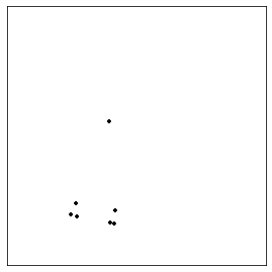

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



In [18]:
# Sample a new image
samp = trees_model.sample()
print("Sample Data: \n\n", samp, samp.shape)

# Visualise the sample
plt.rcParams["figure.dpi"] = 70

out_vis = trees_test.visualise(samp)
plt.imshow(out_vis[0], cmap=out_vis[1], vmin=0, vmax=255)
plt.xticks([])
plt.yticks([])
plt.show()
print("~"*100, "\n")



## Evaluations

### &emsp; &emsp; Setup

In [3]:
# Load datasets
crosses_train = load_pkl("./datasets/crosses_training_50000.pkl")
crosses_test = load_pkl("./datasets/crosses_testing_20000.pkl")

trees_train = load_pkl("./datasets/trees_training_50000_narrow.pkl")
trees_test = load_pkl("./datasets/trees_testing_20000_narrow.pkl")

# trees_train = load_pkl("./datasets/trees_training_50000_wide.pkl")
# trees_test = load_pkl("./datasets/trees_testing_20000_wide.pkl")

In [4]:
# Model Templates
trees_model = HTM(2, 7)
crosses_model = HTM(4, 18)

tree1m_model = HTM(2, 2)


# Load models
trees_model.load_model("trees_lrnd", "./trained_models")
# trees_model.load_model("trees_hrst", "./trained_models")

tree1m_model.load_model("trees_lrnd_2emb_1mrg_narrow", "./trained_models")
# tree1m_model.load_model("trees_lrnd_2emb_1mrg_wide", "./trained_models")

# crosses_model.load_model("crosses_hrst", "./trained_models")
crosses_model.load_model("crosses_lrnd", "./trained_models")


In [5]:
models_data1 = [
    [crosses_model, "Crosses", crosses_train, crosses_test, "crimson", -1],
    [tree1m_model, "Trees (1 mrg.)", trees_train, trees_test, "mediumseagreen", 1],
    [trees_model, "Trees (Root)", trees_train, trees_test, "mediumseagreen", -1],
]

models_data2 = [
    [crosses_model, "Crosses", crosses_train, crosses_test, "crimson"],
    [trees_model, "Trees", trees_train, trees_test, "mediumseagreen"],
]

### &emsp; &emsp; Overfitting Analysis

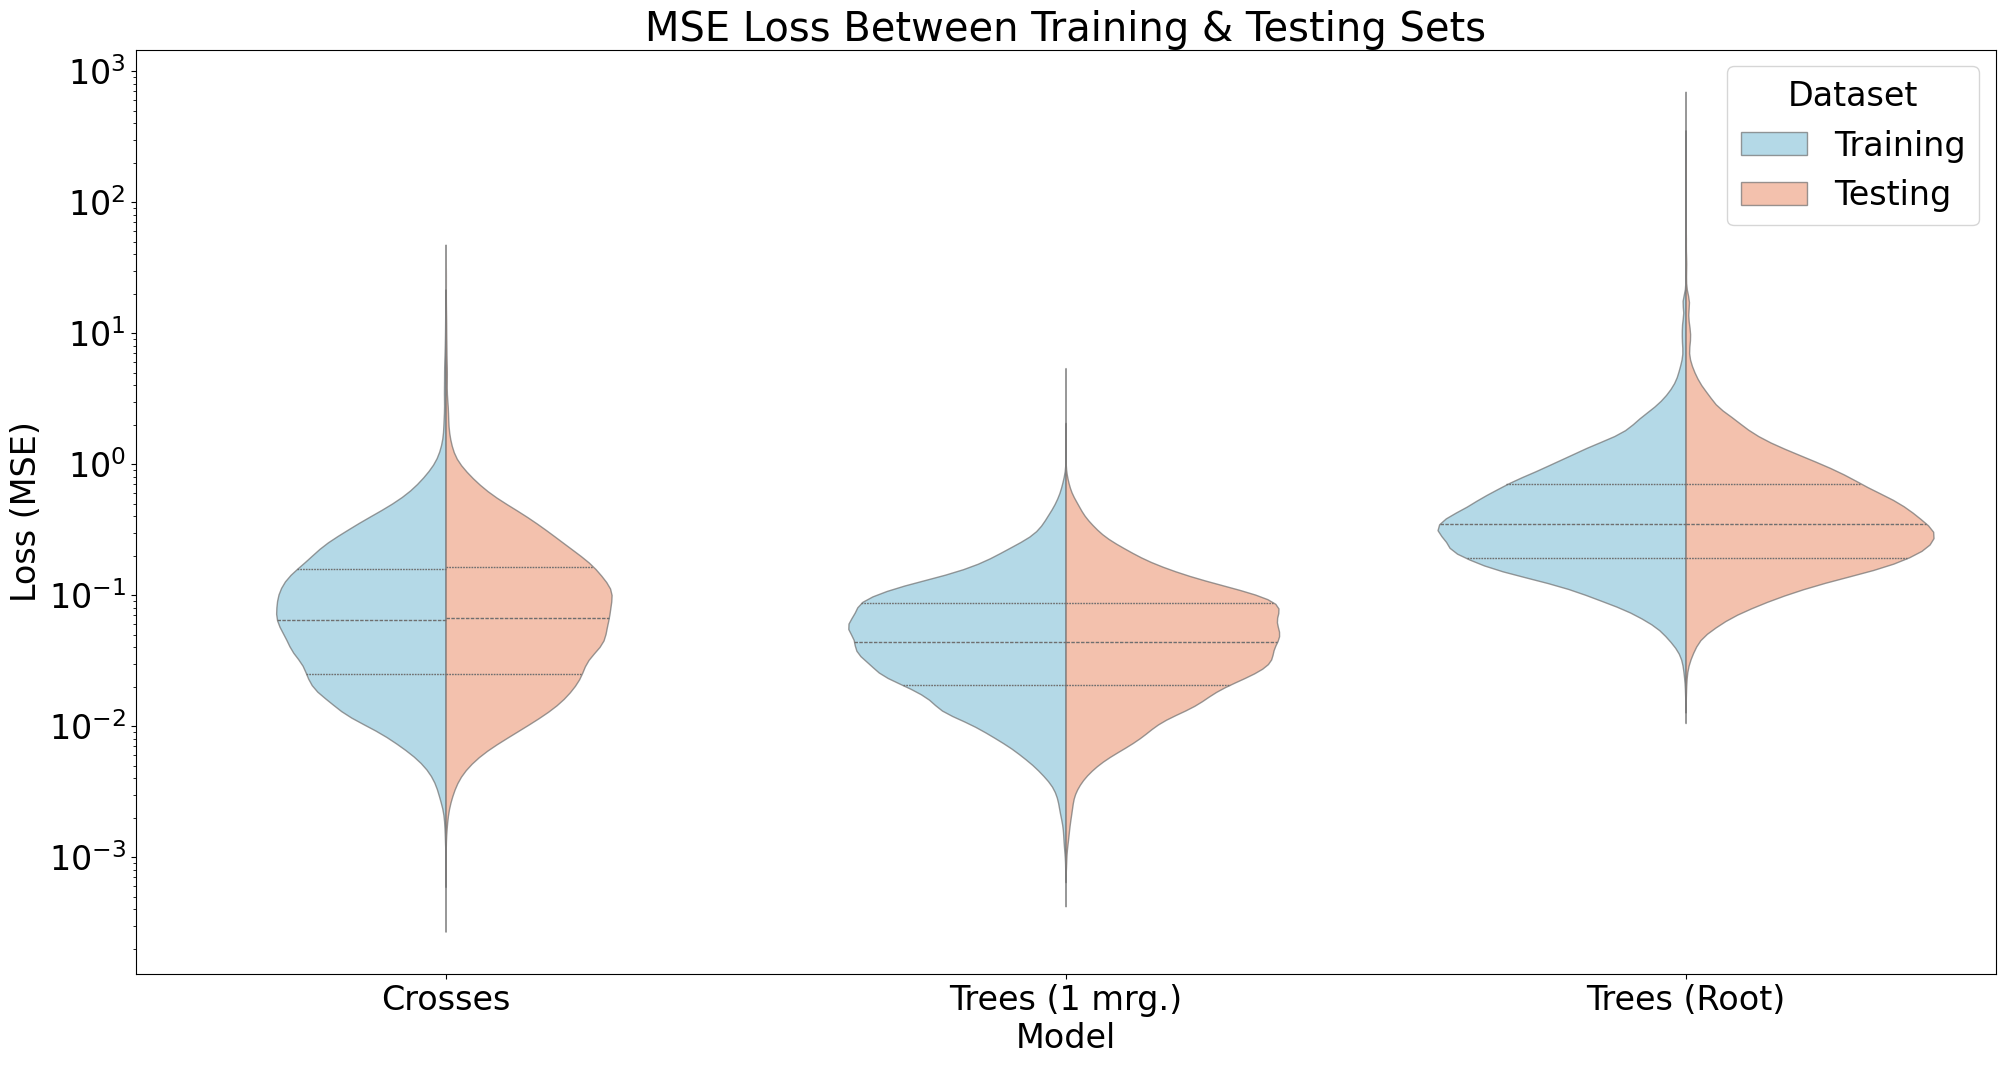

In [7]:
plt.rcParams.update({'font.size': 24})      # (for report)
# plt.rcParams.update({'font.size': 10})      # (default)
reconstruction_eval(models_data1, batch_macro)

### &emsp; &emsp; Classifier Analysis

~~~~~~~~~~~~~~~	  Crosses 	~~~~~~~~~~~~~~~~~

              precision    recall  f1-score   support

      Leaves     0.9998    0.9999    0.9998     79844
      Merged     0.9998    0.9997    0.9998     59844

    accuracy                         0.9998    139688
   macro avg     0.9998    0.9998    0.9998    139688
weighted avg     0.9998    0.9998    0.9998    139688






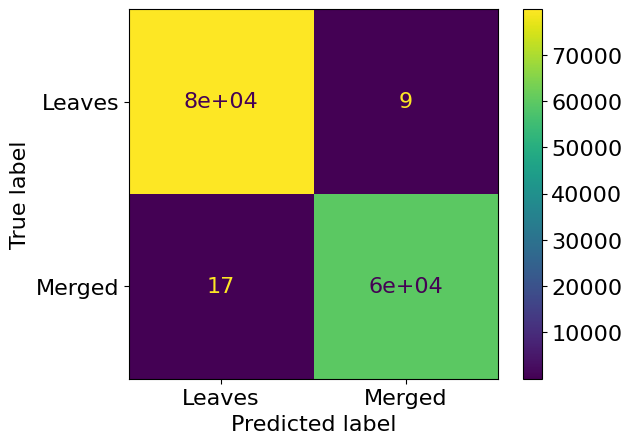




~~~~~~~~~~~~~~~	  Trees 	~~~~~~~~~~~~~~~~~

              precision    recall  f1-score   support

      Leaves     1.0000    1.0000    1.0000    140000
      Merged     1.0000    1.0000    1.0000    120000

    accuracy                         1.0000    260000
   macro avg     1.0000    1.0000    1.0000    260000
weighted avg     1.0000    1.0000    1.0000    260000






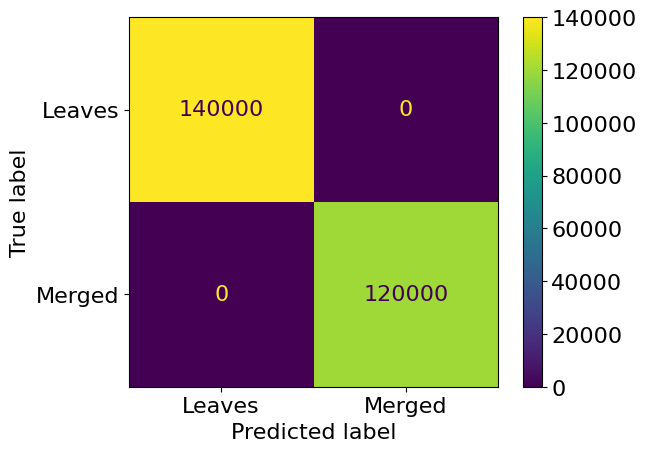

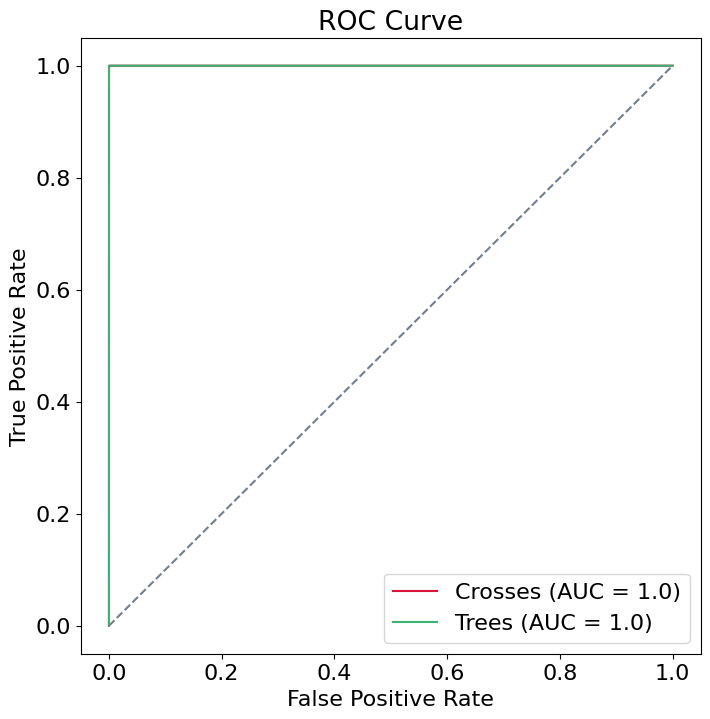

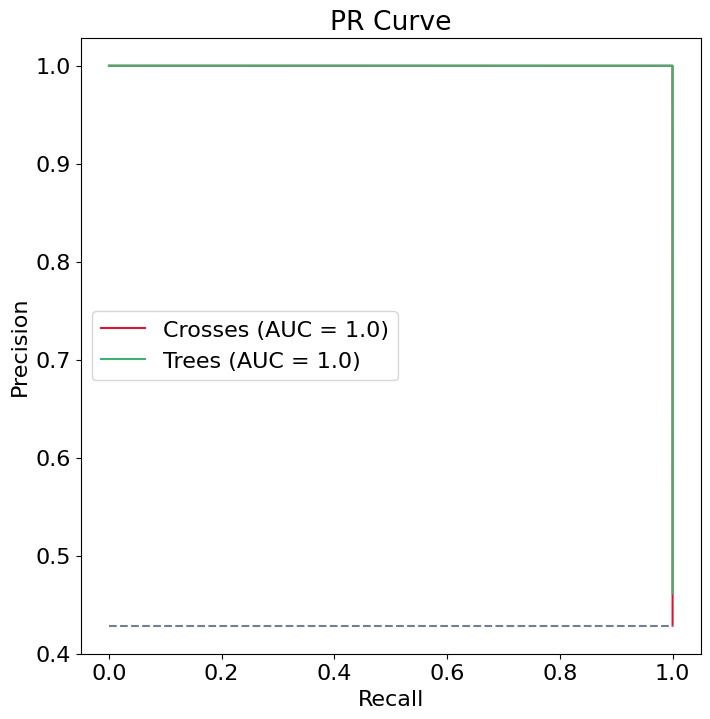

In [7]:
plt.rcParams.update({'font.size': 16})      # (for report)
# plt.rcParams.update({'font.size': 10})      # (default)
clf_eval(models_data2, batch_macro)

### &emsp; &emsp; FID Scores

In [6]:
calculate_fid(models_data2, batch_macro, delete_dirs=True)

Crosses, FID score: 22.825103057988457
Trees, FID score: 3.2514841441634985


## MNIST

### &emsp; &emsp; The Dataset

In [3]:
# Load the training and testing sets
mnist_train = MNIST_DS()
# mnist_train = MNIST_DS(threshv=130)  # 130 default
# mnist_test = MNIST_DS(train=False)

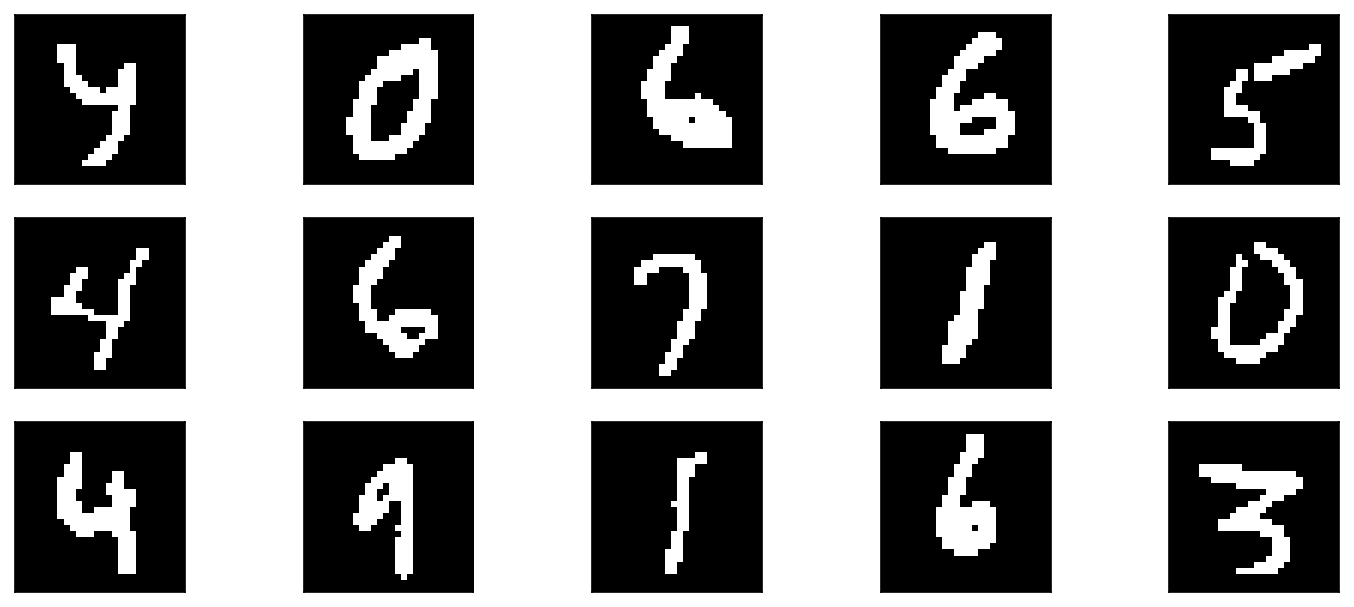

In [4]:
# Display examples of the dataset
eg_ds = mnist_train
# eg_ds = mnist_test

plt.rcParams['figure.dpi'] = 150
fig = plt.figure(figsize=(12, 5))
rows = 3
cols = 5

for i in range(rows * cols):
    fig.add_subplot(rows, cols, i + 1)
    plt.xticks([])
    plt.yticks([])
    # img, cmap = eg_ds.visualise(eg_ds[random.randint(0, len(eg_ds) - 1)])
    img, cmap = eg_ds.visualise(eg_ds.tokenize(eg_ds[random.randint(0, len(eg_ds) - 1)][0]))
    plt.imshow(img, cmap=cmap)

### &emsp; &emsp; Threshold Analysis

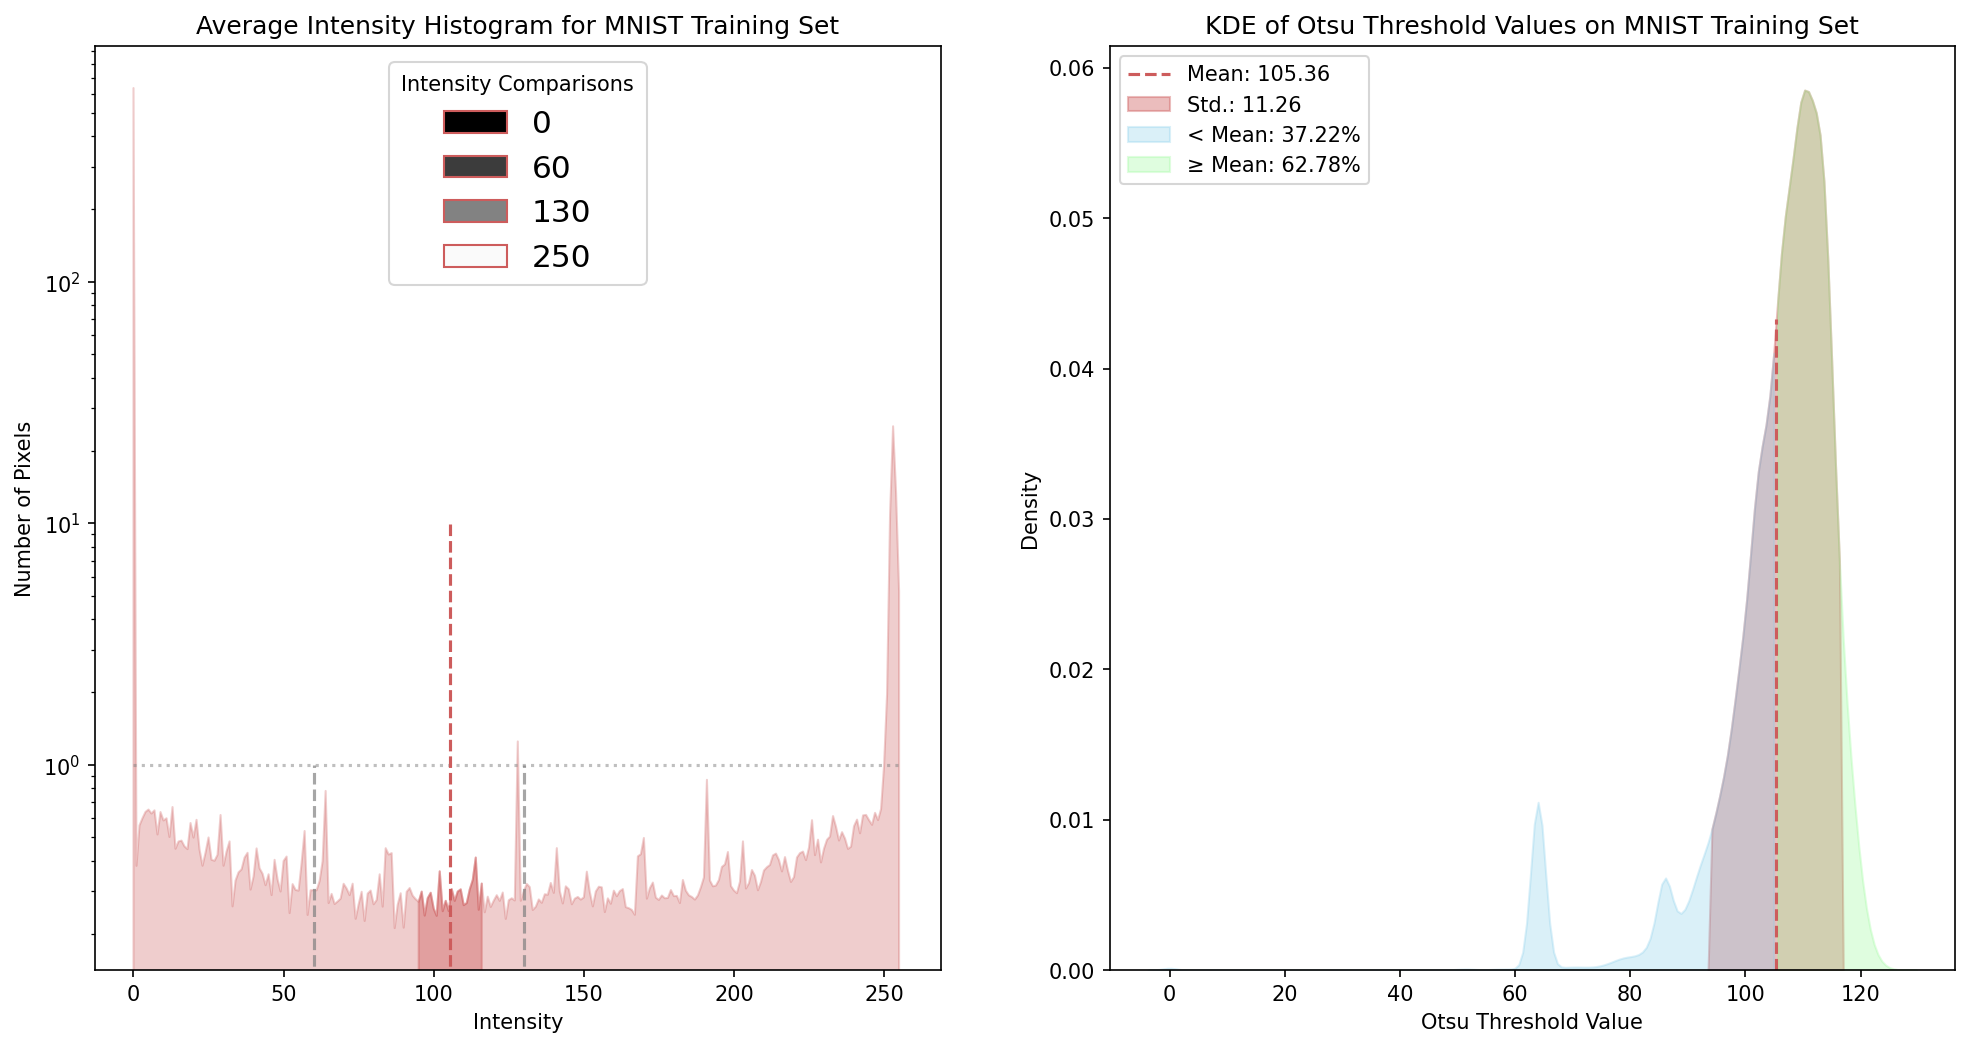

In [27]:
mnist_train.otsu_analysis()

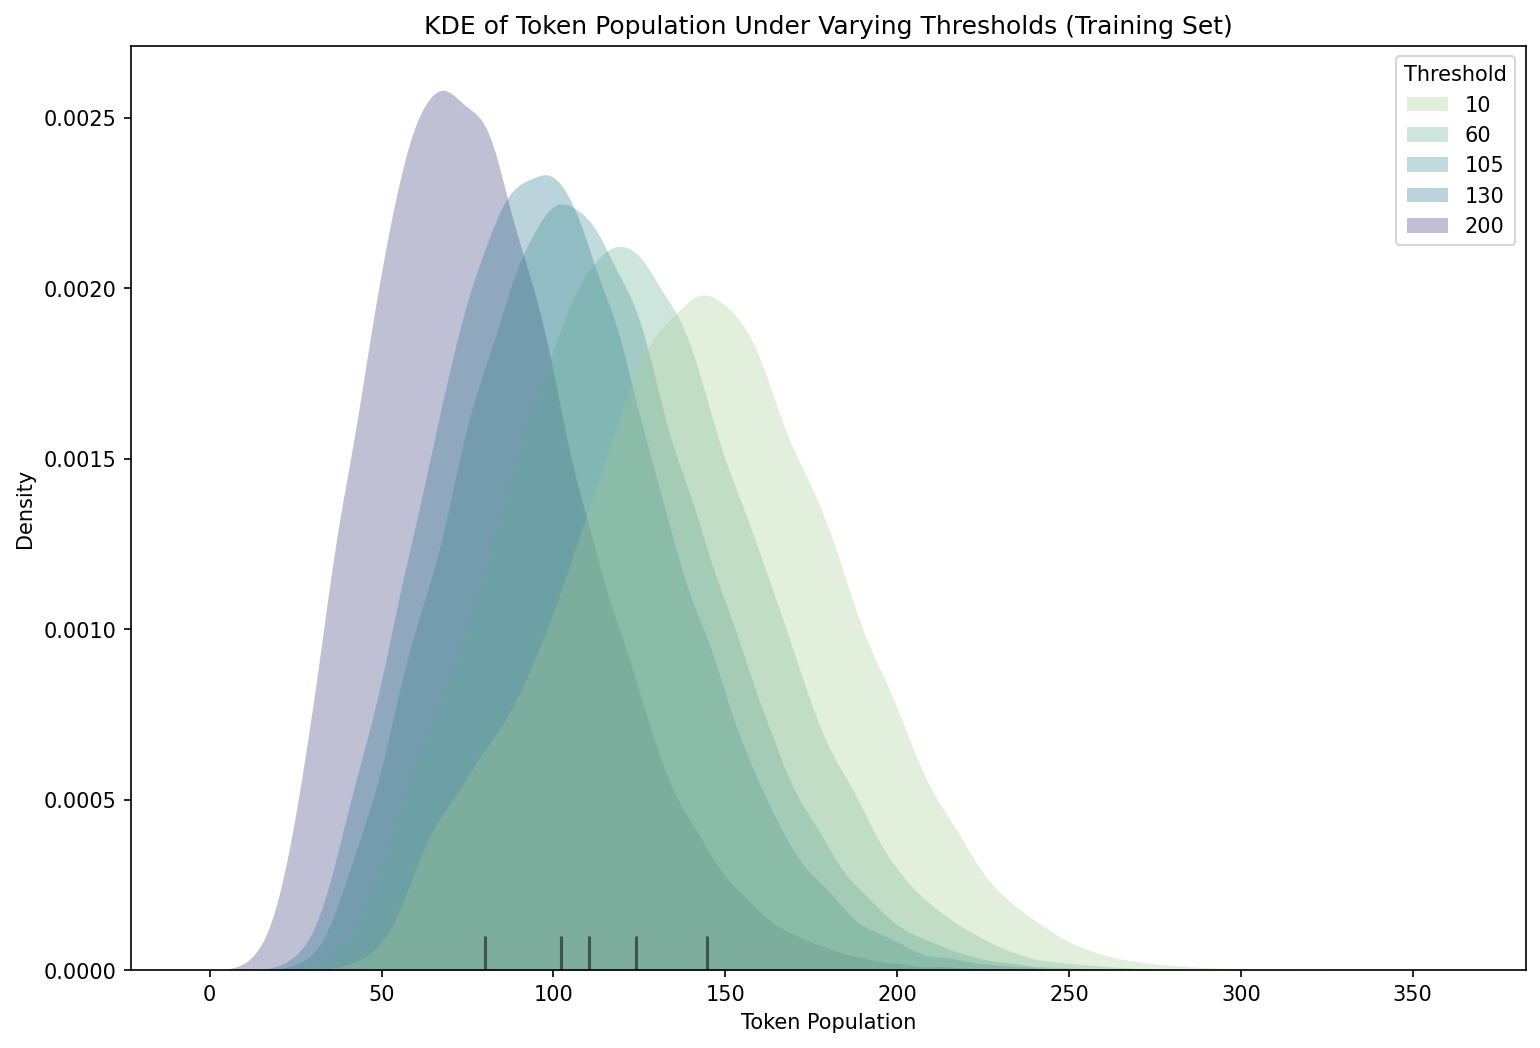

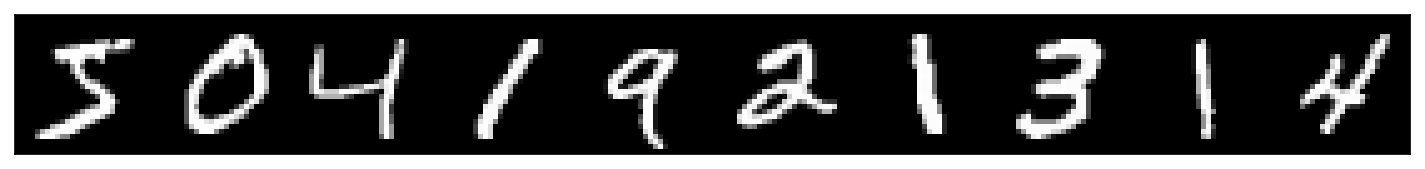

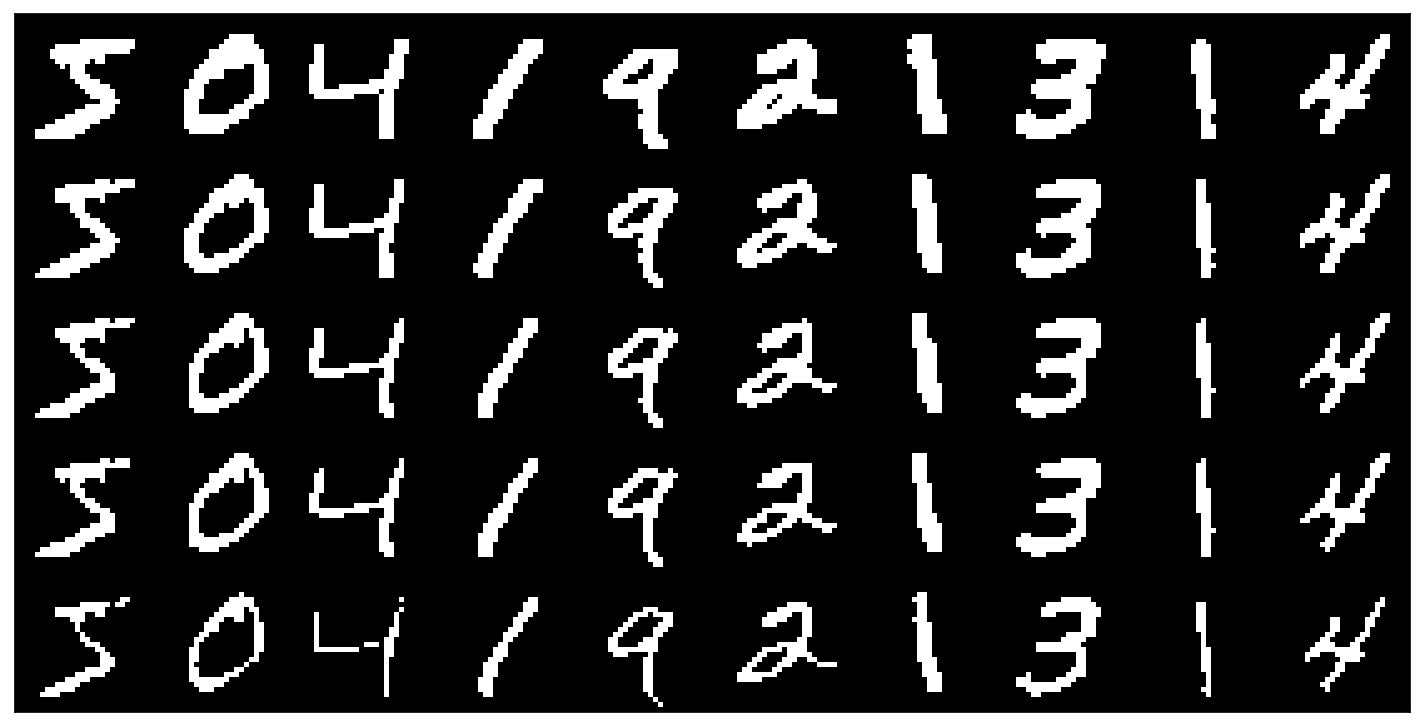

In [26]:
mnist_train.population_analysis()

### &emsp; &emsp; Training

In [ ]:
# Train the HTM model (2 emb. dim, 1 merge only)
model = HTM(
    inp_dim=2,
    emb_dim=30,      
    device=device,

    noise_std=0.1     # typically 0.01                                 
)                                                                        
                                                                            
                                                                           
                                                                            
model.train(
    mnist_train,
    batch_macro = 32,    # making this larger makes it very slow!
    
    # Curriculum Setup
    merges = [0, 1],          
    epochs = [1, 5],    

    # LRs
    lr_lu = [0.05, 0.0005],       
    lr_mu = [None, 0.0005],
    lr_clf = [None]*2,
    lr_pol = [None, 0.0005],

    # LR Decays
    lr_lu_decay = [0, 3],        
    lr_mu_decay = [None, 3],                                                   
    lr_clf_decay = [None]*2,
    lr_pol_decay = [None, 3],

    # Lambdas
    lmbda_lif = [None]*2,
    lmbda_enc = [None]*2,
    lmbda_sl = [0.2]*2,
    lmbda_trns = [0.2]*2,

    lmbda_entrp=3,
    entrp_L=[0.05, 0.10, 0.45, 0.15],

    # Extra
    gen = False,
    policy_v = "heuristic", 
    print_policy=True,
    plt_ivl = 50,
    save = False
)

KeyboardInterrupt: 